In [19]:
from pyspark.sql import SparkSession
allocated_memory = 18 * 0.75

# create a SparkSession
spark = SparkSession.builder.appName("ReadJSON")\
.config("spark.executor.memory", "6g") \
.master("local[*]")  \
.config("spark.driver.memory", "4g") \
.config("spark.network.timeout", "800s")\
.config("spark.executor.heartbeatInterval", "200s")\
.config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.memory.fraction", "0.8") \
.config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.3.3")\
.getOrCreate()

# YOUR FILE PATH MAY BE DIFFERENT, PLEASE ADJUST ACCORDINGLY
json_training_file_path ="../combined_train_data_chunked_10mb_latest.json"

In [20]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

targetUDF = F.udf(lambda x: 1 if x >= 4.0 else 0, IntegerType())

In [21]:
json_objects = []
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType
#"reviewerID": "A8WEXFRWX1ZHH",
# "asin": "0209688726",
# "style": {"Color:": " AC"},
# "reviewerName": "Goldengate",
# Define the schema
schema = StructType([
    StructField("overall", FloatType(), True),
    StructField("verified", BooleanType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("style", StructType([StructField("Color:", StringType(), True)]), True),
    StructField("reviewerName", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("unixReviewTime", IntegerType(), True)

])

def pre_process(chunk, run):
    if run == 0:
        print("Processing chunk")
        df = spark.createDataFrame(json_objects, schema=schema)
        print('Showing original df')
        df.show(20)
        reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
        print('Showing a subset of relevant columns from original df')
        print('Count:', reduced_df.count())
        reduced_df.show(20)
        unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
        print('Showing df after dropping duplicates')
        print('Count:', unique_df.count())
        unique_df.show(20)
        unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
        print('Showing df after removing nulls')
        print('Count:', unique_df.count())
        unique_df.show(20)
        df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
        print('Showing df after adding sentiment column')
        df_sentiment.show(20)
    else:
        df = spark.createDataFrame(json_objects, schema=schema)
        reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
        unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
        unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
        df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
    return df_sentiment

In [22]:
# Building the pipeline for nlp transformers
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])


    nlpPipeline = Pipeline(stages=[
        documentAssembler,
        tokenizer,
        stopwords_cleaner
    ])

    return nlpPipeline

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import NGram, HashingTF, IDF, Tokenizer as MLTokenizer
from pyspark.ml.classification import LogisticRegression

bigram = NGram(inputCol="tokens", outputCol="bigrams", n=2)
tf5   = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)
# create tokens from reviews
tk = MLTokenizer(inputCol= "reviewText", outputCol = "tokens")
# create tf-idf for each of the tokens
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)
# create basic logistic regression model
lr = LogisticRegression(maxIter=20)

bigram_pipeline  = Pipeline(stages= [tk, bigram, tf5, idf, lr])

In [24]:

import sys
import json
import os

from pyspark.ml.pipeline import PipelineModel

def transform_chunk(df, run):
    nlpPipeline = get_nlp_pipeline()
    tokenized_df = nlpPipeline.fit(df).transform(df)
    if run == 0:
        print('Showing tokenized dataframe')
        tokenized_df.show(20)
    df6_train = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
    if run == 0:
        print('Showing processed tokenized dataframe')
        tokenized_df.show(20)
    df_train_for_model = df6_train.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
    return df_train_for_model

# Define the maximum file size in bytes (10MB)
max_file_size = 10 * 1024 * 1024

json_objects = []
run = 0
# Read the file line by line until the maximum file size is reached
with open(json_training_file_path, 'r') as file:
    total_size = 0
    for line in file:
        # Calculate the size of the current line
        line_size = sys.getsizeof(line)

        # If adding the current line exceeds the maximum file size, stop reading
        if total_size + line_size >= max_file_size:
            print('Begin preprocessing')
            # Create a DataFrame from the list of JSON objects
            df = pre_process(json_objects, run)
            # Print only one the first run
            if run == 0:
                print("Show preprocessed chunk:")
                df.show(20)
            df_train = transform_chunk(df, run)
            if run == 0:
                print("Show transformed chunk:")
                df_train.show(20)
            print("Run %d" % run)
            if os.path.exists('bigram_pipeline_model'):
                loaded_model = PipelineModel.load('bigram_pipeline_model')
                stages_steps = loaded_model.stages
                updated_model = Pipeline(stages = stages_steps).fit(df_train)
            else:
                updated_model = bigram_pipeline.fit(df_train)

            updated_model.write().overwrite().save('bigram_pipeline_model')
            run += 1
            print('Model saved for current chunk')
            del df
            del df_train
            json_objects = []
            total_size = 0
        # Otherwise, add the line to the list of JSON objects
        json_objects.append(json.loads(line))
        total_size += line_size

Begin preprocessing
Processing chunk
Showing original df
+-------+--------+-----------+--------------+----------+------+--------------------+--------------------+--------------+
|overall|verified| reviewTime|    reviewerID|      asin| style|        reviewerName|          reviewText|unixReviewTime|
+-------+--------+-----------+--------------+----------+------+--------------------+--------------------+--------------+
|    5.0|    true| 04 5, 2016|A1274GG1EB2JLJ|0486427706|{NULL}|         barbara ann|The pictures are ...|    1459814400|
|    5.0|    true|02 13, 2016|A30X5EGBYAZQQK|0486427706|{NULL}|            Samantha|I absolutely love...|    1455321600|
|    5.0|    true|12 10, 2015|A3U6UNXLAUY6ZV|0486427706|{NULL}|         CP in Texas|          I love it!|    1449705600|
|    5.0|    true|10 26, 2015|A1SAJF5SNM6WJS|0486427706|{NULL}|         LOIS LABIER|MY HUSBAND LOVED ...|    1445817600|
|    4.0|    true|09 15, 2015| AHJWO3SI0S0OR|0486427706|{NULL}|      Saundra Hatley|            

24/04/27 09:58:46 WARN TaskSetManager: Stage 822 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


Count: 17665
+-------+--------------+----------+--------------------+
|overall|    reviewerID|      asin|          reviewText|
+-------+--------------+----------+--------------------+
|    5.0|A1274GG1EB2JLJ|0486427706|The pictures are ...|
|    5.0|A30X5EGBYAZQQK|0486427706|I absolutely love...|
|    5.0|A3U6UNXLAUY6ZV|0486427706|          I love it!|
|    5.0|A1SAJF5SNM6WJS|0486427706|MY HUSBAND LOVED ...|
|    4.0| AHJWO3SI0S0OR|0486427706|                cool|
|    5.0| ALLSNTNR6N6UL|0486427706|Exactly as descri...|
|    1.0|A3O6CP5TT54LJE|0486448789|total waste of mo...|
|    5.0|A216BPGO0ZBR5N|0486448789|Nephew, age 5 lov...|
|    5.0|A3OJCR7TKQIPQM|0486448789|          Very Cute!|
|    3.0|A2DSZOLDOG70GC|0486448789|This is pretty mu...|
|    5.0|A1ZXYT6S1SZ087|0486448789|AGE APPROPIATE. G...|
|    4.0|A3K4NTIXV7Z559|0486448789|its a cute little...|
|    2.0|A3EAVL6N8Q6MOA|0486448789|They were ok but ...|
|    5.0|A15UXQOOJ0TL8K|0486448789|        Good product|
|    4.0| AI3JLLMY

24/04/27 09:58:47 WARN TaskSetManager: Stage 826 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:58:48 WARN TaskSetManager: Stage 832 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


Count: 17602


24/04/27 09:58:49 WARN TaskSetManager: Stage 835 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+
|overall|          reviewerID|      asin|          reviewText|
+-------+--------------------+----------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|                Cute|
|    5.0|      A10DB0H2NZF11E|B00000DMDJ|My son is a huge ...|
|    3.0|      A10HF288PYJ7AF|0975277324|Ticket to Ride

24/04/27 09:58:50 WARN TaskSetManager: Stage 841 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


Count: 17599


+-------+--------------------+----------+--------------------+
|overall|          reviewerID|      asin|          reviewText|
+-------+--------------------+----------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|                Cute|
|    5.0|      A10DB0H2NZF11E|B00000DMDJ|My son is a huge ...|
|    3.0|      A10HF288PYJ7AF|0975277324|Ticket to Ride

24/04/27 09:58:51 WARN TaskSetManager: Stage 844 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:58:52 WARN TaskSetManager: Stage 847 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|        1|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|        0|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|        1|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|        0|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|        1|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|        0|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|          

+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|        1|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|        0|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|        1|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|        0|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|        1|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|        0|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|          

24/04/27 09:58:54 WARN TaskSetManager: Stage 850 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:58:55 WARN TaskSetManager: Stage 853 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|[{document, 0, 68...|[{token, 0, 5, ha...|[{token, 0, 5, ha...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|[{document, 0, 12...|[{token, 0, 4, Th...|[{token, 13, 18, ...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|[{document, 0, 18...|[{token, 0, 6, Pe...|[{token, 0, 6, Pe...|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great t

24/04/27 09:58:57 WARN TaskSetManager: Stage 856 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|[{document, 0, 68...|[{token, 0, 5, ha...|[{token, 0, 5, ha...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|[{document, 0, 12...|[{token, 0, 4, Th...|[{token, 13, 18, ...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|[{document, 0, 18...|[{token, 0, 6, Pe...|[{token, 0, 6, Pe...|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great t

24/04/27 09:58:58 WARN TaskSetManager: Stage 859 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|havent had a chan...|    1|[havent, chance, ...|
|I really wanted t...|    0|[really, wanted, ...|
|There aren't enou...|    1|[enough, adjectiv...|
| Perfect! Thank you!|    1|[Perfect, !, Than...|
|Great travel size...|    1|[Great, travel, s...|
|Falls into itself...|    0|[Falls, stay, ., ...|
|I have only used ...|    1|[used, twice, far...|
|This is pretty mu...|    0|[pretty, much, le...|
|Others have cover...|    1|[Others, covered,...|
|The compact size ...|    0|[compact, size, n...|
|                Cute|    1|              [Cute]|
|My son is a huge ...|    1|[son, huge, Curio...|
|Ticket to Ride is...|    0|[Ticket, Ride, ok...|
|This toy is easil...|    1|[toy, easily, one...|
|I really like Scr...|    1|[really, like, Sc...|
|This is a classic...|    1|[classic, never, ...|
|My grandson loves...|    1|[grandson, loves,...|


24/04/27 09:59:04 WARN TaskSetManager: Stage 862 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:05 WARN TaskSetManager: Stage 863 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/04/27 09:59:18 WARN DAG

Model saved for current chunk
Begin preprocessing
Run 1


24/04/27 09:59:26 WARN TaskSetManager: Stage 951 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:26 WARN TaskSetManager: Stage 955 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 2


24/04/27 09:59:29 WARN TaskSetManager: Stage 979 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:29 WARN TaskSetManager: Stage 983 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 3


24/04/27 09:59:32 WARN TaskSetManager: Stage 1007 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:33 WARN TaskSetManager: Stage 1011 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 4


24/04/27 09:59:36 WARN TaskSetManager: Stage 1035 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:36 WARN TaskSetManager: Stage 1039 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 5


24/04/27 09:59:39 WARN TaskSetManager: Stage 1063 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:39 WARN TaskSetManager: Stage 1067 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 6


24/04/27 09:59:42 WARN TaskSetManager: Stage 1091 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:42 WARN TaskSetManager: Stage 1095 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 7


24/04/27 09:59:46 WARN TaskSetManager: Stage 1119 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:46 WARN TaskSetManager: Stage 1123 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 8


24/04/27 09:59:49 WARN TaskSetManager: Stage 1147 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:49 WARN TaskSetManager: Stage 1151 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 9


24/04/27 09:59:52 WARN TaskSetManager: Stage 1175 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:52 WARN TaskSetManager: Stage 1179 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 10


24/04/27 09:59:55 WARN TaskSetManager: Stage 1203 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 09:59:55 WARN TaskSetManager: Stage 1207 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 11


24/04/27 09:59:59 WARN TaskSetManager: Stage 1231 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:00 WARN TaskSetManager: Stage 1235 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 12


24/04/27 10:00:05 WARN TaskSetManager: Stage 1259 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:05 WARN TaskSetManager: Stage 1263 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 13


24/04/27 10:00:10 WARN TaskSetManager: Stage 1287 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:11 WARN TaskSetManager: Stage 1291 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 14


24/04/27 10:00:16 WARN TaskSetManager: Stage 1315 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:16 WARN TaskSetManager: Stage 1319 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 15


24/04/27 10:00:21 WARN TaskSetManager: Stage 1343 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:22 WARN TaskSetManager: Stage 1347 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 16


24/04/27 10:00:27 WARN TaskSetManager: Stage 1371 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:27 WARN TaskSetManager: Stage 1375 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 17


24/04/27 10:00:32 WARN TaskSetManager: Stage 1399 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:33 WARN TaskSetManager: Stage 1403 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 18


24/04/27 10:00:38 WARN TaskSetManager: Stage 1427 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:38 WARN TaskSetManager: Stage 1431 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 19


24/04/27 10:00:43 WARN TaskSetManager: Stage 1455 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:44 WARN TaskSetManager: Stage 1459 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 20


24/04/27 10:00:49 WARN TaskSetManager: Stage 1483 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:49 WARN TaskSetManager: Stage 1487 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 21


24/04/27 10:00:54 WARN TaskSetManager: Stage 1511 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:00:55 WARN TaskSetManager: Stage 1515 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 22


24/04/27 10:01:00 WARN TaskSetManager: Stage 1539 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:00 WARN TaskSetManager: Stage 1543 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 23


24/04/27 10:01:05 WARN TaskSetManager: Stage 1567 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:06 WARN TaskSetManager: Stage 1571 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 24


24/04/27 10:01:11 WARN TaskSetManager: Stage 1595 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:12 WARN TaskSetManager: Stage 1599 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 25


24/04/27 10:01:17 WARN TaskSetManager: Stage 1623 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:17 WARN TaskSetManager: Stage 1627 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 26


24/04/27 10:01:23 WARN TaskSetManager: Stage 1651 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:23 WARN TaskSetManager: Stage 1655 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 27


24/04/27 10:01:28 WARN TaskSetManager: Stage 1679 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:28 WARN TaskSetManager: Stage 1683 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 28


24/04/27 10:01:33 WARN TaskSetManager: Stage 1707 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:34 WARN TaskSetManager: Stage 1711 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 29


24/04/27 10:01:39 WARN TaskSetManager: Stage 1735 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:39 WARN TaskSetManager: Stage 1739 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 30


24/04/27 10:01:44 WARN TaskSetManager: Stage 1763 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:45 WARN TaskSetManager: Stage 1767 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 31


24/04/27 10:01:50 WARN TaskSetManager: Stage 1791 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:50 WARN TaskSetManager: Stage 1795 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 32


24/04/27 10:01:55 WARN TaskSetManager: Stage 1819 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:01:56 WARN TaskSetManager: Stage 1823 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 33


24/04/27 10:02:01 WARN TaskSetManager: Stage 1847 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:01 WARN TaskSetManager: Stage 1851 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 34


24/04/27 10:02:07 WARN TaskSetManager: Stage 1875 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:07 WARN TaskSetManager: Stage 1879 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 35


24/04/27 10:02:12 WARN TaskSetManager: Stage 1903 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:13 WARN TaskSetManager: Stage 1907 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 36


24/04/27 10:02:17 WARN TaskSetManager: Stage 1931 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:18 WARN TaskSetManager: Stage 1935 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 37


24/04/27 10:02:23 WARN TaskSetManager: Stage 1959 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:24 WARN TaskSetManager: Stage 1963 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 38


24/04/27 10:02:29 WARN TaskSetManager: Stage 1987 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:29 WARN TaskSetManager: Stage 1991 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 39


24/04/27 10:02:35 WARN TaskSetManager: Stage 2015 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:35 WARN TaskSetManager: Stage 2019 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 40


24/04/27 10:02:40 WARN TaskSetManager: Stage 2043 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:41 WARN TaskSetManager: Stage 2047 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 41


24/04/27 10:02:46 WARN TaskSetManager: Stage 2071 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:46 WARN TaskSetManager: Stage 2075 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 42


24/04/27 10:02:51 WARN TaskSetManager: Stage 2099 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:52 WARN TaskSetManager: Stage 2103 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 43


24/04/27 10:02:56 WARN TaskSetManager: Stage 2127 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:02:57 WARN TaskSetManager: Stage 2131 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 44


24/04/27 10:03:02 WARN TaskSetManager: Stage 2155 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:02 WARN TaskSetManager: Stage 2159 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 45


24/04/27 10:03:07 WARN TaskSetManager: Stage 2183 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:08 WARN TaskSetManager: Stage 2187 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 46


24/04/27 10:03:13 WARN TaskSetManager: Stage 2211 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:14 WARN TaskSetManager: Stage 2215 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 47


24/04/27 10:03:18 WARN TaskSetManager: Stage 2239 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:19 WARN TaskSetManager: Stage 2243 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 48


24/04/27 10:03:24 WARN TaskSetManager: Stage 2267 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:24 WARN TaskSetManager: Stage 2271 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 49


24/04/27 10:03:29 WARN TaskSetManager: Stage 2295 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:29 WARN TaskSetManager: Stage 2299 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 50


24/04/27 10:03:34 WARN TaskSetManager: Stage 2323 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:35 WARN TaskSetManager: Stage 2327 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 51


24/04/27 10:03:39 WARN TaskSetManager: Stage 2351 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:40 WARN TaskSetManager: Stage 2355 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 52


24/04/27 10:03:45 WARN TaskSetManager: Stage 2379 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:45 WARN TaskSetManager: Stage 2383 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 53


24/04/27 10:03:50 WARN TaskSetManager: Stage 2407 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:51 WARN TaskSetManager: Stage 2411 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 54


24/04/27 10:03:56 WARN TaskSetManager: Stage 2435 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:03:56 WARN TaskSetManager: Stage 2439 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 55


24/04/27 10:04:01 WARN TaskSetManager: Stage 2463 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:02 WARN TaskSetManager: Stage 2467 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 56


24/04/27 10:04:07 WARN TaskSetManager: Stage 2491 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:07 WARN TaskSetManager: Stage 2495 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 57


24/04/27 10:04:12 WARN TaskSetManager: Stage 2519 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:12 WARN TaskSetManager: Stage 2523 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 58


24/04/27 10:04:17 WARN TaskSetManager: Stage 2547 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:18 WARN TaskSetManager: Stage 2551 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 59


24/04/27 10:04:22 WARN TaskSetManager: Stage 2575 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:23 WARN TaskSetManager: Stage 2579 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 60


24/04/27 10:04:28 WARN TaskSetManager: Stage 2603 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:28 WARN TaskSetManager: Stage 2607 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 61


24/04/27 10:04:34 WARN TaskSetManager: Stage 2631 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:34 WARN TaskSetManager: Stage 2635 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 62


24/04/27 10:04:39 WARN TaskSetManager: Stage 2659 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:39 WARN TaskSetManager: Stage 2663 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 63


24/04/27 10:04:44 WARN TaskSetManager: Stage 2687 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:45 WARN TaskSetManager: Stage 2691 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 64


24/04/27 10:04:50 WARN TaskSetManager: Stage 2715 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:50 WARN TaskSetManager: Stage 2719 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 65


24/04/27 10:04:55 WARN TaskSetManager: Stage 2743 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:04:56 WARN TaskSetManager: Stage 2747 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 66


24/04/27 10:05:01 WARN TaskSetManager: Stage 2771 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:01 WARN TaskSetManager: Stage 2775 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 67


24/04/27 10:05:07 WARN TaskSetManager: Stage 2799 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:07 WARN TaskSetManager: Stage 2803 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 68


24/04/27 10:05:12 WARN TaskSetManager: Stage 2827 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:13 WARN TaskSetManager: Stage 2831 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 69


24/04/27 10:05:18 WARN TaskSetManager: Stage 2855 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:18 WARN TaskSetManager: Stage 2859 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 70


24/04/27 10:05:24 WARN TaskSetManager: Stage 2883 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:24 WARN TaskSetManager: Stage 2887 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 71


24/04/27 10:05:29 WARN TaskSetManager: Stage 2911 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:30 WARN TaskSetManager: Stage 2915 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 72


24/04/27 10:05:35 WARN TaskSetManager: Stage 2939 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:36 WARN TaskSetManager: Stage 2943 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 73


24/04/27 10:05:41 WARN TaskSetManager: Stage 2967 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:41 WARN TaskSetManager: Stage 2971 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 74


24/04/27 10:05:46 WARN TaskSetManager: Stage 2995 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:47 WARN TaskSetManager: Stage 2999 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 75


24/04/27 10:05:52 WARN TaskSetManager: Stage 3023 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:52 WARN TaskSetManager: Stage 3027 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 76


24/04/27 10:05:57 WARN TaskSetManager: Stage 3051 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:05:58 WARN TaskSetManager: Stage 3055 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 77


24/04/27 10:06:03 WARN TaskSetManager: Stage 3079 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:03 WARN TaskSetManager: Stage 3083 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 78


24/04/27 10:06:08 WARN TaskSetManager: Stage 3107 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:09 WARN TaskSetManager: Stage 3111 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 79


24/04/27 10:06:13 WARN TaskSetManager: Stage 3135 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:14 WARN TaskSetManager: Stage 3139 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 80


24/04/27 10:06:19 WARN TaskSetManager: Stage 3163 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:19 WARN TaskSetManager: Stage 3167 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 81


24/04/27 10:06:25 WARN TaskSetManager: Stage 3191 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:25 WARN TaskSetManager: Stage 3195 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 82


24/04/27 10:06:30 WARN TaskSetManager: Stage 3219 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:31 WARN TaskSetManager: Stage 3223 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 83


24/04/27 10:06:35 WARN TaskSetManager: Stage 3247 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:36 WARN TaskSetManager: Stage 3251 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 84


24/04/27 10:06:41 WARN TaskSetManager: Stage 3275 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:41 WARN TaskSetManager: Stage 3279 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 85


24/04/27 10:06:46 WARN TaskSetManager: Stage 3303 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:47 WARN TaskSetManager: Stage 3307 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 86


24/04/27 10:06:52 WARN TaskSetManager: Stage 3331 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:53 WARN TaskSetManager: Stage 3335 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 87


24/04/27 10:06:58 WARN TaskSetManager: Stage 3359 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:06:58 WARN TaskSetManager: Stage 3363 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 88


24/04/27 10:07:03 WARN TaskSetManager: Stage 3387 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:04 WARN TaskSetManager: Stage 3391 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 89


24/04/27 10:07:09 WARN TaskSetManager: Stage 3415 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:10 WARN TaskSetManager: Stage 3419 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 90


24/04/27 10:07:15 WARN TaskSetManager: Stage 3443 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:15 WARN TaskSetManager: Stage 3447 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 91


24/04/27 10:07:20 WARN TaskSetManager: Stage 3471 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:21 WARN TaskSetManager: Stage 3475 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 92


24/04/27 10:07:26 WARN TaskSetManager: Stage 3499 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:26 WARN TaskSetManager: Stage 3503 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 93


24/04/27 10:07:32 WARN TaskSetManager: Stage 3527 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:33 WARN TaskSetManager: Stage 3531 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 94


24/04/27 10:07:38 WARN TaskSetManager: Stage 3555 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:38 WARN TaskSetManager: Stage 3559 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 95


24/04/27 10:07:43 WARN TaskSetManager: Stage 3583 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:44 WARN TaskSetManager: Stage 3587 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 96


24/04/27 10:07:48 WARN TaskSetManager: Stage 3611 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:49 WARN TaskSetManager: Stage 3615 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 97


24/04/27 10:07:54 WARN TaskSetManager: Stage 3639 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:07:54 WARN TaskSetManager: Stage 3643 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 98


24/04/27 10:08:00 WARN TaskSetManager: Stage 3667 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:00 WARN TaskSetManager: Stage 3671 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 99


24/04/27 10:08:05 WARN TaskSetManager: Stage 3695 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:05 WARN TaskSetManager: Stage 3699 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 100


24/04/27 10:08:10 WARN TaskSetManager: Stage 3723 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:11 WARN TaskSetManager: Stage 3727 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 101


24/04/27 10:08:16 WARN TaskSetManager: Stage 3751 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:16 WARN TaskSetManager: Stage 3755 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 102


24/04/27 10:08:21 WARN TaskSetManager: Stage 3779 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:22 WARN TaskSetManager: Stage 3783 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 103


24/04/27 10:08:27 WARN TaskSetManager: Stage 3807 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:27 WARN TaskSetManager: Stage 3811 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 104


24/04/27 10:08:32 WARN TaskSetManager: Stage 3835 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:33 WARN TaskSetManager: Stage 3839 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 105


24/04/27 10:08:38 WARN TaskSetManager: Stage 3863 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:39 WARN TaskSetManager: Stage 3867 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 106


24/04/27 10:08:44 WARN TaskSetManager: Stage 3891 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:44 WARN TaskSetManager: Stage 3895 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 107


24/04/27 10:08:50 WARN TaskSetManager: Stage 3919 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:50 WARN TaskSetManager: Stage 3923 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 108


24/04/27 10:08:55 WARN TaskSetManager: Stage 3947 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:08:56 WARN TaskSetManager: Stage 3951 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 109


24/04/27 10:09:00 WARN TaskSetManager: Stage 3975 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:01 WARN TaskSetManager: Stage 3979 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 110


24/04/27 10:09:06 WARN TaskSetManager: Stage 4003 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:07 WARN TaskSetManager: Stage 4007 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 111


24/04/27 10:09:12 WARN TaskSetManager: Stage 4031 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:12 WARN TaskSetManager: Stage 4035 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 112


24/04/27 10:09:17 WARN TaskSetManager: Stage 4059 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:18 WARN TaskSetManager: Stage 4063 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 113


24/04/27 10:09:22 WARN TaskSetManager: Stage 4087 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:23 WARN TaskSetManager: Stage 4091 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 114


24/04/27 10:09:27 WARN TaskSetManager: Stage 4115 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:28 WARN TaskSetManager: Stage 4119 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 115


24/04/27 10:09:31 WARN TaskSetManager: Stage 4143 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:31 WARN TaskSetManager: Stage 4147 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 116


24/04/27 10:09:34 WARN TaskSetManager: Stage 4171 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:34 WARN TaskSetManager: Stage 4175 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 117


24/04/27 10:09:37 WARN TaskSetManager: Stage 4199 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:37 WARN TaskSetManager: Stage 4203 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 118


24/04/27 10:09:39 WARN TaskSetManager: Stage 4227 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:40 WARN TaskSetManager: Stage 4231 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 119


24/04/27 10:09:42 WARN TaskSetManager: Stage 4255 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:43 WARN TaskSetManager: Stage 4259 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 120


24/04/27 10:09:46 WARN TaskSetManager: Stage 4283 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:46 WARN TaskSetManager: Stage 4287 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 121


24/04/27 10:09:49 WARN TaskSetManager: Stage 4311 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:49 WARN TaskSetManager: Stage 4315 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 122


24/04/27 10:09:52 WARN TaskSetManager: Stage 4339 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:52 WARN TaskSetManager: Stage 4343 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 123


24/04/27 10:09:55 WARN TaskSetManager: Stage 4367 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:55 WARN TaskSetManager: Stage 4371 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 124


24/04/27 10:09:58 WARN TaskSetManager: Stage 4395 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:09:58 WARN TaskSetManager: Stage 4399 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 125


24/04/27 10:10:01 WARN TaskSetManager: Stage 4423 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:01 WARN TaskSetManager: Stage 4427 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 126


24/04/27 10:10:04 WARN TaskSetManager: Stage 4451 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:04 WARN TaskSetManager: Stage 4455 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 127


24/04/27 10:10:07 WARN TaskSetManager: Stage 4479 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:07 WARN TaskSetManager: Stage 4483 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 128


24/04/27 10:10:10 WARN TaskSetManager: Stage 4507 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:11 WARN TaskSetManager: Stage 4511 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 129


24/04/27 10:10:13 WARN TaskSetManager: Stage 4535 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:14 WARN TaskSetManager: Stage 4539 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 130


24/04/27 10:10:16 WARN TaskSetManager: Stage 4563 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:17 WARN TaskSetManager: Stage 4567 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 131


24/04/27 10:10:19 WARN TaskSetManager: Stage 4591 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:20 WARN TaskSetManager: Stage 4595 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 132


24/04/27 10:10:22 WARN TaskSetManager: Stage 4619 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:23 WARN TaskSetManager: Stage 4623 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 133


24/04/27 10:10:25 WARN TaskSetManager: Stage 4647 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:26 WARN TaskSetManager: Stage 4651 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 134


24/04/27 10:10:28 WARN TaskSetManager: Stage 4675 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:29 WARN TaskSetManager: Stage 4679 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 135


24/04/27 10:10:31 WARN TaskSetManager: Stage 4703 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:31 WARN TaskSetManager: Stage 4707 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 136


24/04/27 10:10:34 WARN TaskSetManager: Stage 4731 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:34 WARN TaskSetManager: Stage 4735 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 137


24/04/27 10:10:37 WARN TaskSetManager: Stage 4759 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:38 WARN TaskSetManager: Stage 4763 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 138


24/04/27 10:10:40 WARN TaskSetManager: Stage 4787 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:41 WARN TaskSetManager: Stage 4791 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 139


24/04/27 10:10:43 WARN TaskSetManager: Stage 4815 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:44 WARN TaskSetManager: Stage 4819 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 140


24/04/27 10:10:46 WARN TaskSetManager: Stage 4843 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:47 WARN TaskSetManager: Stage 4847 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 141


24/04/27 10:10:49 WARN TaskSetManager: Stage 4871 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:49 WARN TaskSetManager: Stage 4875 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 142


24/04/27 10:10:52 WARN TaskSetManager: Stage 4899 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:52 WARN TaskSetManager: Stage 4903 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 143


24/04/27 10:10:55 WARN TaskSetManager: Stage 4927 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:55 WARN TaskSetManager: Stage 4931 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 144


24/04/27 10:10:58 WARN TaskSetManager: Stage 4955 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:10:58 WARN TaskSetManager: Stage 4959 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 145


24/04/27 10:11:01 WARN TaskSetManager: Stage 4983 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:01 WARN TaskSetManager: Stage 4987 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 146


24/04/27 10:11:04 WARN TaskSetManager: Stage 5011 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:04 WARN TaskSetManager: Stage 5015 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 147


24/04/27 10:11:07 WARN TaskSetManager: Stage 5039 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:07 WARN TaskSetManager: Stage 5043 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 148


24/04/27 10:11:10 WARN TaskSetManager: Stage 5067 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:10 WARN TaskSetManager: Stage 5071 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 149


24/04/27 10:11:12 WARN TaskSetManager: Stage 5095 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:13 WARN TaskSetManager: Stage 5099 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 150


24/04/27 10:11:15 WARN TaskSetManager: Stage 5123 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:16 WARN TaskSetManager: Stage 5127 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 151


24/04/27 10:11:18 WARN TaskSetManager: Stage 5151 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:18 WARN TaskSetManager: Stage 5155 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 152


24/04/27 10:11:21 WARN TaskSetManager: Stage 5179 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:21 WARN TaskSetManager: Stage 5183 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 153


24/04/27 10:11:24 WARN TaskSetManager: Stage 5207 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:24 WARN TaskSetManager: Stage 5211 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 154


24/04/27 10:11:28 WARN TaskSetManager: Stage 5235 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:28 WARN TaskSetManager: Stage 5239 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 155


24/04/27 10:11:32 WARN TaskSetManager: Stage 5263 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:32 WARN TaskSetManager: Stage 5267 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 156


24/04/27 10:11:35 WARN TaskSetManager: Stage 5291 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:35 WARN TaskSetManager: Stage 5295 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 157


24/04/27 10:11:40 WARN TaskSetManager: Stage 5319 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:40 WARN TaskSetManager: Stage 5323 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 158


24/04/27 10:11:45 WARN TaskSetManager: Stage 5347 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:46 WARN TaskSetManager: Stage 5351 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 159


24/04/27 10:11:50 WARN TaskSetManager: Stage 5375 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:51 WARN TaskSetManager: Stage 5379 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 160


24/04/27 10:11:56 WARN TaskSetManager: Stage 5403 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:11:57 WARN TaskSetManager: Stage 5407 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 161


24/04/27 10:12:02 WARN TaskSetManager: Stage 5431 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:02 WARN TaskSetManager: Stage 5435 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 162


24/04/27 10:12:07 WARN TaskSetManager: Stage 5459 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:08 WARN TaskSetManager: Stage 5463 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 163


24/04/27 10:12:12 WARN TaskSetManager: Stage 5487 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:13 WARN TaskSetManager: Stage 5491 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 164


24/04/27 10:12:17 WARN TaskSetManager: Stage 5515 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:18 WARN TaskSetManager: Stage 5519 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 165


24/04/27 10:12:22 WARN TaskSetManager: Stage 5543 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:23 WARN TaskSetManager: Stage 5547 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 166


24/04/27 10:12:27 WARN TaskSetManager: Stage 5571 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:27 WARN TaskSetManager: Stage 5575 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 167


24/04/27 10:12:32 WARN TaskSetManager: Stage 5599 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:32 WARN TaskSetManager: Stage 5603 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 168


24/04/27 10:12:37 WARN TaskSetManager: Stage 5627 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:37 WARN TaskSetManager: Stage 5631 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 169


24/04/27 10:12:42 WARN TaskSetManager: Stage 5655 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:42 WARN TaskSetManager: Stage 5659 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 170


24/04/27 10:12:47 WARN TaskSetManager: Stage 5683 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:47 WARN TaskSetManager: Stage 5687 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 171


24/04/27 10:12:52 WARN TaskSetManager: Stage 5711 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:52 WARN TaskSetManager: Stage 5715 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 172


24/04/27 10:12:57 WARN TaskSetManager: Stage 5739 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:12:57 WARN TaskSetManager: Stage 5743 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 173


24/04/27 10:13:02 WARN TaskSetManager: Stage 5767 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:02 WARN TaskSetManager: Stage 5771 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 174


24/04/27 10:13:07 WARN TaskSetManager: Stage 5795 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:07 WARN TaskSetManager: Stage 5799 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 175


24/04/27 10:13:12 WARN TaskSetManager: Stage 5823 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:12 WARN TaskSetManager: Stage 5827 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 176


24/04/27 10:13:17 WARN TaskSetManager: Stage 5851 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:17 WARN TaskSetManager: Stage 5855 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 177


24/04/27 10:13:22 WARN TaskSetManager: Stage 5879 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:22 WARN TaskSetManager: Stage 5883 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 178


24/04/27 10:13:27 WARN TaskSetManager: Stage 5907 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:27 WARN TaskSetManager: Stage 5911 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 179


24/04/27 10:13:31 WARN TaskSetManager: Stage 5935 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:32 WARN TaskSetManager: Stage 5939 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 180


24/04/27 10:13:37 WARN TaskSetManager: Stage 5963 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:37 WARN TaskSetManager: Stage 5967 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 181


24/04/27 10:13:42 WARN TaskSetManager: Stage 5991 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:42 WARN TaskSetManager: Stage 5995 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 182


24/04/27 10:13:47 WARN TaskSetManager: Stage 6019 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:47 WARN TaskSetManager: Stage 6023 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 183


24/04/27 10:13:52 WARN TaskSetManager: Stage 6047 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:52 WARN TaskSetManager: Stage 6051 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 184


24/04/27 10:13:57 WARN TaskSetManager: Stage 6075 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:13:58 WARN TaskSetManager: Stage 6079 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 185


24/04/27 10:14:02 WARN TaskSetManager: Stage 6103 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:03 WARN TaskSetManager: Stage 6107 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 186


24/04/27 10:14:07 WARN TaskSetManager: Stage 6131 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:07 WARN TaskSetManager: Stage 6135 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 187


24/04/27 10:14:12 WARN TaskSetManager: Stage 6159 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:13 WARN TaskSetManager: Stage 6163 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 188


24/04/27 10:14:17 WARN TaskSetManager: Stage 6187 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:18 WARN TaskSetManager: Stage 6191 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 189


24/04/27 10:14:23 WARN TaskSetManager: Stage 6215 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:24 WARN TaskSetManager: Stage 6219 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 190


24/04/27 10:14:28 WARN TaskSetManager: Stage 6243 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:29 WARN TaskSetManager: Stage 6247 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 191


24/04/27 10:14:33 WARN TaskSetManager: Stage 6271 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:34 WARN TaskSetManager: Stage 6275 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 192


24/04/27 10:14:39 WARN TaskSetManager: Stage 6299 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:39 WARN TaskSetManager: Stage 6303 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 193


24/04/27 10:14:44 WARN TaskSetManager: Stage 6327 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:44 WARN TaskSetManager: Stage 6331 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 194


24/04/27 10:14:49 WARN TaskSetManager: Stage 6355 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:50 WARN TaskSetManager: Stage 6359 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 195


24/04/27 10:14:54 WARN TaskSetManager: Stage 6383 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:14:55 WARN TaskSetManager: Stage 6387 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 196


24/04/27 10:14:59 WARN TaskSetManager: Stage 6411 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:00 WARN TaskSetManager: Stage 6415 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 197


24/04/27 10:15:04 WARN TaskSetManager: Stage 6439 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:05 WARN TaskSetManager: Stage 6443 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 198


24/04/27 10:15:09 WARN TaskSetManager: Stage 6467 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:10 WARN TaskSetManager: Stage 6471 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 199


24/04/27 10:15:14 WARN TaskSetManager: Stage 6495 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:15 WARN TaskSetManager: Stage 6499 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 200


24/04/27 10:15:20 WARN TaskSetManager: Stage 6523 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:20 WARN TaskSetManager: Stage 6527 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 201


24/04/27 10:15:25 WARN TaskSetManager: Stage 6551 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:25 WARN TaskSetManager: Stage 6555 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 202


24/04/27 10:15:30 WARN TaskSetManager: Stage 6579 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:31 WARN TaskSetManager: Stage 6583 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 203


24/04/27 10:15:36 WARN TaskSetManager: Stage 6607 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:36 WARN TaskSetManager: Stage 6611 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 204


24/04/27 10:15:41 WARN TaskSetManager: Stage 6635 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:42 WARN TaskSetManager: Stage 6639 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 205


24/04/27 10:15:47 WARN TaskSetManager: Stage 6663 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:47 WARN TaskSetManager: Stage 6667 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 206


24/04/27 10:15:52 WARN TaskSetManager: Stage 6691 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:53 WARN TaskSetManager: Stage 6695 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 207


24/04/27 10:15:58 WARN TaskSetManager: Stage 6719 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:15:58 WARN TaskSetManager: Stage 6723 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 208


24/04/27 10:16:02 WARN TaskSetManager: Stage 6747 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:03 WARN TaskSetManager: Stage 6751 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 209


24/04/27 10:16:08 WARN TaskSetManager: Stage 6775 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:08 WARN TaskSetManager: Stage 6779 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 210


24/04/27 10:16:13 WARN TaskSetManager: Stage 6803 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:13 WARN TaskSetManager: Stage 6807 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 211


24/04/27 10:16:18 WARN TaskSetManager: Stage 6831 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:18 WARN TaskSetManager: Stage 6835 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 212


24/04/27 10:16:23 WARN TaskSetManager: Stage 6859 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:23 WARN TaskSetManager: Stage 6863 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 213


24/04/27 10:16:28 WARN TaskSetManager: Stage 6887 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:28 WARN TaskSetManager: Stage 6891 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 214


24/04/27 10:16:33 WARN TaskSetManager: Stage 6915 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:33 WARN TaskSetManager: Stage 6919 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 215


24/04/27 10:16:38 WARN TaskSetManager: Stage 6943 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:39 WARN TaskSetManager: Stage 6947 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 216


24/04/27 10:16:43 WARN TaskSetManager: Stage 6971 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:44 WARN TaskSetManager: Stage 6975 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 217


24/04/27 10:16:49 WARN TaskSetManager: Stage 6999 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:49 WARN TaskSetManager: Stage 7003 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 218


24/04/27 10:16:54 WARN TaskSetManager: Stage 7027 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:16:54 WARN TaskSetManager: Stage 7031 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 219


24/04/27 10:16:59 WARN TaskSetManager: Stage 7055 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:00 WARN TaskSetManager: Stage 7059 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 220


24/04/27 10:17:04 WARN TaskSetManager: Stage 7083 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:05 WARN TaskSetManager: Stage 7087 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 221


24/04/27 10:17:10 WARN TaskSetManager: Stage 7111 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:10 WARN TaskSetManager: Stage 7115 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 222


24/04/27 10:17:14 WARN TaskSetManager: Stage 7139 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:15 WARN TaskSetManager: Stage 7143 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 223


24/04/27 10:17:19 WARN TaskSetManager: Stage 7167 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:20 WARN TaskSetManager: Stage 7171 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 224


24/04/27 10:17:24 WARN TaskSetManager: Stage 7195 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:25 WARN TaskSetManager: Stage 7199 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 225


24/04/27 10:17:29 WARN TaskSetManager: Stage 7223 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:30 WARN TaskSetManager: Stage 7227 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 226


24/04/27 10:17:34 WARN TaskSetManager: Stage 7251 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:35 WARN TaskSetManager: Stage 7255 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 227


24/04/27 10:17:40 WARN TaskSetManager: Stage 7279 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:40 WARN TaskSetManager: Stage 7283 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 228


24/04/27 10:17:45 WARN TaskSetManager: Stage 7307 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:45 WARN TaskSetManager: Stage 7311 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 229


24/04/27 10:17:50 WARN TaskSetManager: Stage 7335 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:51 WARN TaskSetManager: Stage 7339 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 230


24/04/27 10:17:55 WARN TaskSetManager: Stage 7363 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:17:56 WARN TaskSetManager: Stage 7367 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 231


24/04/27 10:18:00 WARN TaskSetManager: Stage 7391 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:01 WARN TaskSetManager: Stage 7395 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 232


24/04/27 10:18:05 WARN TaskSetManager: Stage 7419 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:06 WARN TaskSetManager: Stage 7423 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 233


24/04/27 10:18:10 WARN TaskSetManager: Stage 7447 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:11 WARN TaskSetManager: Stage 7451 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 234


24/04/27 10:18:15 WARN TaskSetManager: Stage 7475 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:16 WARN TaskSetManager: Stage 7479 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 235


24/04/27 10:18:20 WARN TaskSetManager: Stage 7503 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:21 WARN TaskSetManager: Stage 7507 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 236


24/04/27 10:18:26 WARN TaskSetManager: Stage 7531 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:26 WARN TaskSetManager: Stage 7535 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 237


24/04/27 10:18:31 WARN TaskSetManager: Stage 7559 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:32 WARN TaskSetManager: Stage 7563 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 238


24/04/27 10:18:37 WARN TaskSetManager: Stage 7587 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:37 WARN TaskSetManager: Stage 7591 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 239


24/04/27 10:18:43 WARN TaskSetManager: Stage 7615 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:43 WARN TaskSetManager: Stage 7619 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 240


24/04/27 10:18:48 WARN TaskSetManager: Stage 7643 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:49 WARN TaskSetManager: Stage 7647 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 241


24/04/27 10:18:53 WARN TaskSetManager: Stage 7671 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:18:54 WARN TaskSetManager: Stage 7675 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 242


24/04/27 10:18:59 WARN TaskSetManager: Stage 7699 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:00 WARN TaskSetManager: Stage 7703 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 243


24/04/27 10:19:05 WARN TaskSetManager: Stage 7727 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:05 WARN TaskSetManager: Stage 7731 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 244


24/04/27 10:19:10 WARN TaskSetManager: Stage 7755 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:11 WARN TaskSetManager: Stage 7759 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 245


24/04/27 10:19:15 WARN TaskSetManager: Stage 7783 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:16 WARN TaskSetManager: Stage 7787 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 246


24/04/27 10:19:21 WARN TaskSetManager: Stage 7811 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:21 WARN TaskSetManager: Stage 7815 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 247


24/04/27 10:19:26 WARN TaskSetManager: Stage 7839 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:27 WARN TaskSetManager: Stage 7843 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 248


24/04/27 10:19:35 WARN TaskSetManager: Stage 7867 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:35 WARN TaskSetManager: Stage 7871 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 249


24/04/27 10:19:40 WARN TaskSetManager: Stage 7895 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:41 WARN TaskSetManager: Stage 7899 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 250


24/04/27 10:19:46 WARN TaskSetManager: Stage 7923 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:47 WARN TaskSetManager: Stage 7927 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 251


24/04/27 10:19:52 WARN TaskSetManager: Stage 7951 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:53 WARN TaskSetManager: Stage 7955 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 252


24/04/27 10:19:59 WARN TaskSetManager: Stage 7979 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:19:59 WARN TaskSetManager: Stage 7983 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 253


24/04/27 10:20:04 WARN TaskSetManager: Stage 8007 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:05 WARN TaskSetManager: Stage 8011 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 254


24/04/27 10:20:10 WARN TaskSetManager: Stage 8035 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:11 WARN TaskSetManager: Stage 8039 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 255


24/04/27 10:20:16 WARN TaskSetManager: Stage 8063 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:17 WARN TaskSetManager: Stage 8067 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 256


24/04/27 10:20:22 WARN TaskSetManager: Stage 8091 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:23 WARN TaskSetManager: Stage 8095 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 257


24/04/27 10:20:28 WARN TaskSetManager: Stage 8119 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:28 WARN TaskSetManager: Stage 8123 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 258


24/04/27 10:20:34 WARN TaskSetManager: Stage 8147 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:35 WARN TaskSetManager: Stage 8151 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 259


24/04/27 10:20:41 WARN TaskSetManager: Stage 8175 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:41 WARN TaskSetManager: Stage 8179 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 260


24/04/27 10:20:48 WARN TaskSetManager: Stage 8203 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:49 WARN TaskSetManager: Stage 8207 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 261


24/04/27 10:20:54 WARN TaskSetManager: Stage 8231 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:20:55 WARN TaskSetManager: Stage 8235 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 262


24/04/27 10:21:00 WARN TaskSetManager: Stage 8259 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:01 WARN TaskSetManager: Stage 8263 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 263


24/04/27 10:21:06 WARN TaskSetManager: Stage 8287 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:07 WARN TaskSetManager: Stage 8291 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 264


24/04/27 10:21:14 WARN TaskSetManager: Stage 8315 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:14 WARN TaskSetManager: Stage 8319 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 265


24/04/27 10:21:20 WARN TaskSetManager: Stage 8343 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:21 WARN TaskSetManager: Stage 8347 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 266


24/04/27 10:21:26 WARN TaskSetManager: Stage 8371 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:27 WARN TaskSetManager: Stage 8375 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 267


24/04/27 10:21:32 WARN TaskSetManager: Stage 8399 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:33 WARN TaskSetManager: Stage 8403 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 268


24/04/27 10:21:38 WARN TaskSetManager: Stage 8427 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:38 WARN TaskSetManager: Stage 8431 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 269


24/04/27 10:21:44 WARN TaskSetManager: Stage 8455 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:45 WARN TaskSetManager: Stage 8459 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 270


24/04/27 10:21:50 WARN TaskSetManager: Stage 8483 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:51 WARN TaskSetManager: Stage 8487 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 271


24/04/27 10:21:56 WARN TaskSetManager: Stage 8511 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:21:56 WARN TaskSetManager: Stage 8515 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 272


24/04/27 10:22:01 WARN TaskSetManager: Stage 8539 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:02 WARN TaskSetManager: Stage 8543 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 273


24/04/27 10:22:08 WARN TaskSetManager: Stage 8567 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:08 WARN TaskSetManager: Stage 8571 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 274


24/04/27 10:22:14 WARN TaskSetManager: Stage 8595 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:14 WARN TaskSetManager: Stage 8599 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 275


24/04/27 10:22:20 WARN TaskSetManager: Stage 8623 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:20 WARN TaskSetManager: Stage 8627 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 276


24/04/27 10:22:25 WARN TaskSetManager: Stage 8651 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:26 WARN TaskSetManager: Stage 8655 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 277


24/04/27 10:22:31 WARN TaskSetManager: Stage 8679 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:32 WARN TaskSetManager: Stage 8683 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 278


24/04/27 10:22:37 WARN TaskSetManager: Stage 8707 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:37 WARN TaskSetManager: Stage 8711 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 279


24/04/27 10:22:42 WARN TaskSetManager: Stage 8735 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:43 WARN TaskSetManager: Stage 8739 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 280


24/04/27 10:22:48 WARN TaskSetManager: Stage 8763 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:49 WARN TaskSetManager: Stage 8767 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 281


24/04/27 10:22:53 WARN TaskSetManager: Stage 8791 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:22:54 WARN TaskSetManager: Stage 8795 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 282


24/04/27 10:23:00 WARN TaskSetManager: Stage 8819 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:01 WARN TaskSetManager: Stage 8823 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 283


24/04/27 10:23:05 WARN TaskSetManager: Stage 8847 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:06 WARN TaskSetManager: Stage 8851 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 284


24/04/27 10:23:11 WARN TaskSetManager: Stage 8875 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:11 WARN TaskSetManager: Stage 8879 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 285


24/04/27 10:23:17 WARN TaskSetManager: Stage 8903 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:17 WARN TaskSetManager: Stage 8907 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 286


24/04/27 10:23:22 WARN TaskSetManager: Stage 8931 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:23 WARN TaskSetManager: Stage 8935 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 287


24/04/27 10:23:28 WARN TaskSetManager: Stage 8959 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:28 WARN TaskSetManager: Stage 8963 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 288


24/04/27 10:23:34 WARN TaskSetManager: Stage 8987 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:35 WARN TaskSetManager: Stage 8991 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 289


24/04/27 10:23:41 WARN TaskSetManager: Stage 9015 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:42 WARN TaskSetManager: Stage 9019 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 290


24/04/27 10:23:47 WARN TaskSetManager: Stage 9043 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:48 WARN TaskSetManager: Stage 9047 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 291


24/04/27 10:23:55 WARN TaskSetManager: Stage 9071 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:23:55 WARN TaskSetManager: Stage 9075 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 292


24/04/27 10:24:01 WARN TaskSetManager: Stage 9099 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:02 WARN TaskSetManager: Stage 9103 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 293


24/04/27 10:24:08 WARN TaskSetManager: Stage 9127 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:09 WARN TaskSetManager: Stage 9131 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 294


24/04/27 10:24:14 WARN TaskSetManager: Stage 9155 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:15 WARN TaskSetManager: Stage 9159 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 295


24/04/27 10:24:20 WARN TaskSetManager: Stage 9183 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:21 WARN TaskSetManager: Stage 9187 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 296


24/04/27 10:24:26 WARN TaskSetManager: Stage 9211 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:27 WARN TaskSetManager: Stage 9215 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 297


24/04/27 10:24:32 WARN TaskSetManager: Stage 9239 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:33 WARN TaskSetManager: Stage 9243 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 298


24/04/27 10:24:39 WARN TaskSetManager: Stage 9267 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:39 WARN TaskSetManager: Stage 9271 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 299


24/04/27 10:24:45 WARN TaskSetManager: Stage 9295 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:46 WARN TaskSetManager: Stage 9299 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 300


24/04/27 10:24:51 WARN TaskSetManager: Stage 9323 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:52 WARN TaskSetManager: Stage 9327 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 301


24/04/27 10:24:57 WARN TaskSetManager: Stage 9351 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:24:58 WARN TaskSetManager: Stage 9355 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 302


24/04/27 10:25:03 WARN TaskSetManager: Stage 9379 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:04 WARN TaskSetManager: Stage 9383 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 303


24/04/27 10:25:09 WARN TaskSetManager: Stage 9407 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:10 WARN TaskSetManager: Stage 9411 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 304


24/04/27 10:25:15 WARN TaskSetManager: Stage 9435 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:16 WARN TaskSetManager: Stage 9439 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 305


24/04/27 10:25:21 WARN TaskSetManager: Stage 9463 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:22 WARN TaskSetManager: Stage 9467 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 306


24/04/27 10:25:26 WARN TaskSetManager: Stage 9491 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:27 WARN TaskSetManager: Stage 9495 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 307


24/04/27 10:25:32 WARN TaskSetManager: Stage 9519 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:33 WARN TaskSetManager: Stage 9523 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 308


24/04/27 10:25:38 WARN TaskSetManager: Stage 9547 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:38 WARN TaskSetManager: Stage 9551 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 309


24/04/27 10:25:44 WARN TaskSetManager: Stage 9575 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:44 WARN TaskSetManager: Stage 9579 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 310


24/04/27 10:25:49 WARN TaskSetManager: Stage 9603 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:50 WARN TaskSetManager: Stage 9607 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 311


24/04/27 10:25:55 WARN TaskSetManager: Stage 9631 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:25:55 WARN TaskSetManager: Stage 9635 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 312


24/04/27 10:26:00 WARN TaskSetManager: Stage 9659 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:01 WARN TaskSetManager: Stage 9663 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 313


24/04/27 10:26:06 WARN TaskSetManager: Stage 9687 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:07 WARN TaskSetManager: Stage 9691 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 314


24/04/27 10:26:13 WARN TaskSetManager: Stage 9715 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:14 WARN TaskSetManager: Stage 9719 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 315


24/04/27 10:26:20 WARN TaskSetManager: Stage 9743 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:20 WARN TaskSetManager: Stage 9747 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 316


24/04/27 10:26:26 WARN TaskSetManager: Stage 9771 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:27 WARN TaskSetManager: Stage 9775 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 317


24/04/27 10:26:33 WARN TaskSetManager: Stage 9799 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:33 WARN TaskSetManager: Stage 9803 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 318


24/04/27 10:26:39 WARN TaskSetManager: Stage 9827 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:39 WARN TaskSetManager: Stage 9831 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 319


24/04/27 10:26:45 WARN TaskSetManager: Stage 9855 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:46 WARN TaskSetManager: Stage 9859 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 320


24/04/27 10:26:52 WARN TaskSetManager: Stage 9883 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:52 WARN TaskSetManager: Stage 9887 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 321


24/04/27 10:26:58 WARN TaskSetManager: Stage 9911 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:26:58 WARN TaskSetManager: Stage 9915 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 322


24/04/27 10:27:04 WARN TaskSetManager: Stage 9939 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:05 WARN TaskSetManager: Stage 9943 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 323


24/04/27 10:27:10 WARN TaskSetManager: Stage 9967 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:11 WARN TaskSetManager: Stage 9971 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 324


24/04/27 10:27:16 WARN TaskSetManager: Stage 9995 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:17 WARN TaskSetManager: Stage 9999 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 325


24/04/27 10:27:22 WARN TaskSetManager: Stage 10023 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:23 WARN TaskSetManager: Stage 10027 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 326


24/04/27 10:27:28 WARN TaskSetManager: Stage 10051 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:29 WARN TaskSetManager: Stage 10055 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 327


24/04/27 10:27:35 WARN TaskSetManager: Stage 10079 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:36 WARN TaskSetManager: Stage 10083 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 328


24/04/27 10:27:41 WARN TaskSetManager: Stage 10107 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:42 WARN TaskSetManager: Stage 10111 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 329


24/04/27 10:27:47 WARN TaskSetManager: Stage 10135 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:48 WARN TaskSetManager: Stage 10139 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 330


24/04/27 10:27:53 WARN TaskSetManager: Stage 10163 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:27:54 WARN TaskSetManager: Stage 10167 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 331


24/04/27 10:28:00 WARN TaskSetManager: Stage 10191 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:01 WARN TaskSetManager: Stage 10195 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 332


24/04/27 10:28:06 WARN TaskSetManager: Stage 10219 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:07 WARN TaskSetManager: Stage 10223 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 333


24/04/27 10:28:13 WARN TaskSetManager: Stage 10247 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:13 WARN TaskSetManager: Stage 10251 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 334


24/04/27 10:28:20 WARN TaskSetManager: Stage 10275 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:20 WARN TaskSetManager: Stage 10279 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 335


24/04/27 10:28:27 WARN TaskSetManager: Stage 10303 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:27 WARN TaskSetManager: Stage 10307 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 336


24/04/27 10:28:33 WARN TaskSetManager: Stage 10331 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:34 WARN TaskSetManager: Stage 10335 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 337


24/04/27 10:28:39 WARN TaskSetManager: Stage 10359 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:40 WARN TaskSetManager: Stage 10363 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 338


24/04/27 10:28:46 WARN TaskSetManager: Stage 10387 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:47 WARN TaskSetManager: Stage 10391 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 339


24/04/27 10:28:52 WARN TaskSetManager: Stage 10415 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:53 WARN TaskSetManager: Stage 10419 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 340


24/04/27 10:28:59 WARN TaskSetManager: Stage 10443 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:28:59 WARN TaskSetManager: Stage 10447 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 341


24/04/27 10:29:05 WARN TaskSetManager: Stage 10471 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:06 WARN TaskSetManager: Stage 10475 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 342


24/04/27 10:29:11 WARN TaskSetManager: Stage 10499 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:12 WARN TaskSetManager: Stage 10503 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 343


24/04/27 10:29:17 WARN TaskSetManager: Stage 10527 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:18 WARN TaskSetManager: Stage 10531 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 344


24/04/27 10:29:23 WARN TaskSetManager: Stage 10555 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:24 WARN TaskSetManager: Stage 10559 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 345


24/04/27 10:29:29 WARN TaskSetManager: Stage 10583 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:30 WARN TaskSetManager: Stage 10587 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 346


24/04/27 10:29:35 WARN TaskSetManager: Stage 10611 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:36 WARN TaskSetManager: Stage 10615 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 347


24/04/27 10:29:41 WARN TaskSetManager: Stage 10639 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:41 WARN TaskSetManager: Stage 10643 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 348


24/04/27 10:29:46 WARN TaskSetManager: Stage 10667 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:47 WARN TaskSetManager: Stage 10671 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 349


24/04/27 10:29:52 WARN TaskSetManager: Stage 10695 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:52 WARN TaskSetManager: Stage 10699 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 350


24/04/27 10:29:57 WARN TaskSetManager: Stage 10723 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:29:58 WARN TaskSetManager: Stage 10727 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 351


24/04/27 10:30:03 WARN TaskSetManager: Stage 10751 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:03 WARN TaskSetManager: Stage 10755 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 352


24/04/27 10:30:10 WARN TaskSetManager: Stage 10779 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:10 WARN TaskSetManager: Stage 10783 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 353


24/04/27 10:30:15 WARN TaskSetManager: Stage 10807 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:16 WARN TaskSetManager: Stage 10811 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 354


24/04/27 10:30:21 WARN TaskSetManager: Stage 10835 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:22 WARN TaskSetManager: Stage 10839 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 355


24/04/27 10:30:27 WARN TaskSetManager: Stage 10863 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:28 WARN TaskSetManager: Stage 10867 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 356


24/04/27 10:30:33 WARN TaskSetManager: Stage 10891 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:34 WARN TaskSetManager: Stage 10895 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 357


24/04/27 10:30:39 WARN TaskSetManager: Stage 10919 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:39 WARN TaskSetManager: Stage 10923 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 358


24/04/27 10:30:44 WARN TaskSetManager: Stage 10947 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:45 WARN TaskSetManager: Stage 10951 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 359


24/04/27 10:30:50 WARN TaskSetManager: Stage 10975 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:50 WARN TaskSetManager: Stage 10979 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 360


24/04/27 10:30:55 WARN TaskSetManager: Stage 11003 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:30:55 WARN TaskSetManager: Stage 11007 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 361


24/04/27 10:31:00 WARN TaskSetManager: Stage 11031 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:01 WARN TaskSetManager: Stage 11035 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 362


24/04/27 10:31:06 WARN TaskSetManager: Stage 11059 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:06 WARN TaskSetManager: Stage 11063 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 363


24/04/27 10:31:12 WARN TaskSetManager: Stage 11087 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:12 WARN TaskSetManager: Stage 11091 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 364


24/04/27 10:31:18 WARN TaskSetManager: Stage 11115 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:18 WARN TaskSetManager: Stage 11119 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 365


24/04/27 10:31:24 WARN TaskSetManager: Stage 11143 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:25 WARN TaskSetManager: Stage 11147 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 366


24/04/27 10:31:30 WARN TaskSetManager: Stage 11171 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:30 WARN TaskSetManager: Stage 11175 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 367


24/04/27 10:31:36 WARN TaskSetManager: Stage 11199 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:36 WARN TaskSetManager: Stage 11203 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 368


24/04/27 10:31:41 WARN TaskSetManager: Stage 11227 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:42 WARN TaskSetManager: Stage 11231 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 369


24/04/27 10:31:47 WARN TaskSetManager: Stage 11255 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:47 WARN TaskSetManager: Stage 11259 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 370


24/04/27 10:31:52 WARN TaskSetManager: Stage 11283 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:53 WARN TaskSetManager: Stage 11287 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 371


24/04/27 10:31:58 WARN TaskSetManager: Stage 11311 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:31:59 WARN TaskSetManager: Stage 11315 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 372


24/04/27 10:32:05 WARN TaskSetManager: Stage 11339 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:06 WARN TaskSetManager: Stage 11343 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 373


24/04/27 10:32:12 WARN TaskSetManager: Stage 11367 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:13 WARN TaskSetManager: Stage 11371 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 374


24/04/27 10:32:18 WARN TaskSetManager: Stage 11395 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:19 WARN TaskSetManager: Stage 11399 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 375


24/04/27 10:32:24 WARN TaskSetManager: Stage 11423 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:24 WARN TaskSetManager: Stage 11427 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 376


24/04/27 10:32:29 WARN TaskSetManager: Stage 11451 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:29 WARN TaskSetManager: Stage 11455 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 377


24/04/27 10:32:34 WARN TaskSetManager: Stage 11479 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:35 WARN TaskSetManager: Stage 11483 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 378


24/04/27 10:32:40 WARN TaskSetManager: Stage 11507 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:41 WARN TaskSetManager: Stage 11511 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 379


24/04/27 10:32:46 WARN TaskSetManager: Stage 11535 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:47 WARN TaskSetManager: Stage 11539 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 380


24/04/27 10:32:53 WARN TaskSetManager: Stage 11563 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:32:54 WARN TaskSetManager: Stage 11567 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 381


24/04/27 10:33:00 WARN TaskSetManager: Stage 11591 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:01 WARN TaskSetManager: Stage 11595 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 382


24/04/27 10:33:07 WARN TaskSetManager: Stage 11619 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:08 WARN TaskSetManager: Stage 11623 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 383


24/04/27 10:33:13 WARN TaskSetManager: Stage 11647 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:14 WARN TaskSetManager: Stage 11651 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 384


24/04/27 10:33:19 WARN TaskSetManager: Stage 11675 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:20 WARN TaskSetManager: Stage 11679 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 385


24/04/27 10:33:26 WARN TaskSetManager: Stage 11703 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:26 WARN TaskSetManager: Stage 11707 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 386


24/04/27 10:33:32 WARN TaskSetManager: Stage 11731 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:33 WARN TaskSetManager: Stage 11735 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 387


24/04/27 10:33:38 WARN TaskSetManager: Stage 11759 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:39 WARN TaskSetManager: Stage 11763 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 388


24/04/27 10:33:44 WARN TaskSetManager: Stage 11787 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:45 WARN TaskSetManager: Stage 11791 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 389


24/04/27 10:33:50 WARN TaskSetManager: Stage 11815 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:50 WARN TaskSetManager: Stage 11819 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 390


24/04/27 10:33:55 WARN TaskSetManager: Stage 11843 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:33:56 WARN TaskSetManager: Stage 11847 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 391


24/04/27 10:34:01 WARN TaskSetManager: Stage 11871 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:01 WARN TaskSetManager: Stage 11875 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 392


24/04/27 10:34:07 WARN TaskSetManager: Stage 11899 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:08 WARN TaskSetManager: Stage 11903 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 393


24/04/27 10:34:13 WARN TaskSetManager: Stage 11927 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:14 WARN TaskSetManager: Stage 11931 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 394


24/04/27 10:34:19 WARN TaskSetManager: Stage 11955 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:20 WARN TaskSetManager: Stage 11959 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 395


24/04/27 10:34:26 WARN TaskSetManager: Stage 11983 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:27 WARN TaskSetManager: Stage 11987 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 396


24/04/27 10:34:32 WARN TaskSetManager: Stage 12011 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:33 WARN TaskSetManager: Stage 12015 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 397


24/04/27 10:34:38 WARN TaskSetManager: Stage 12039 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:39 WARN TaskSetManager: Stage 12043 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 398


24/04/27 10:34:43 WARN TaskSetManager: Stage 12067 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:44 WARN TaskSetManager: Stage 12071 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 399


24/04/27 10:34:49 WARN TaskSetManager: Stage 12095 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:50 WARN TaskSetManager: Stage 12099 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 400


24/04/27 10:34:55 WARN TaskSetManager: Stage 12123 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:34:55 WARN TaskSetManager: Stage 12127 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 401


24/04/27 10:35:00 WARN TaskSetManager: Stage 12151 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:00 WARN TaskSetManager: Stage 12155 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 402


24/04/27 10:35:06 WARN TaskSetManager: Stage 12179 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:07 WARN TaskSetManager: Stage 12183 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 403


24/04/27 10:35:13 WARN TaskSetManager: Stage 12207 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:14 WARN TaskSetManager: Stage 12211 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 404


24/04/27 10:35:19 WARN TaskSetManager: Stage 12235 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:20 WARN TaskSetManager: Stage 12239 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 405


24/04/27 10:35:25 WARN TaskSetManager: Stage 12263 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:26 WARN TaskSetManager: Stage 12267 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 406


24/04/27 10:35:31 WARN TaskSetManager: Stage 12291 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:32 WARN TaskSetManager: Stage 12295 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 407


24/04/27 10:35:36 WARN TaskSetManager: Stage 12319 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:37 WARN TaskSetManager: Stage 12323 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 408


24/04/27 10:35:43 WARN TaskSetManager: Stage 12347 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:44 WARN TaskSetManager: Stage 12351 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 409


24/04/27 10:35:50 WARN TaskSetManager: Stage 12375 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:50 WARN TaskSetManager: Stage 12379 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 410


24/04/27 10:35:56 WARN TaskSetManager: Stage 12403 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:35:57 WARN TaskSetManager: Stage 12407 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 411


24/04/27 10:36:02 WARN TaskSetManager: Stage 12431 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:03 WARN TaskSetManager: Stage 12435 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 412


24/04/27 10:36:08 WARN TaskSetManager: Stage 12459 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:09 WARN TaskSetManager: Stage 12463 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 413


24/04/27 10:36:14 WARN TaskSetManager: Stage 12487 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:15 WARN TaskSetManager: Stage 12491 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 414


24/04/27 10:36:20 WARN TaskSetManager: Stage 12515 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:20 WARN TaskSetManager: Stage 12519 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 415


24/04/27 10:36:26 WARN TaskSetManager: Stage 12543 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:26 WARN TaskSetManager: Stage 12547 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 416


24/04/27 10:36:32 WARN TaskSetManager: Stage 12571 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:32 WARN TaskSetManager: Stage 12575 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 417


24/04/27 10:36:37 WARN TaskSetManager: Stage 12599 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:38 WARN TaskSetManager: Stage 12603 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 418


24/04/27 10:36:44 WARN TaskSetManager: Stage 12627 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:45 WARN TaskSetManager: Stage 12631 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 419


24/04/27 10:36:50 WARN TaskSetManager: Stage 12655 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:50 WARN TaskSetManager: Stage 12659 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 420


24/04/27 10:36:56 WARN TaskSetManager: Stage 12683 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:36:56 WARN TaskSetManager: Stage 12687 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 421


24/04/27 10:37:02 WARN TaskSetManager: Stage 12711 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:02 WARN TaskSetManager: Stage 12715 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 422


24/04/27 10:37:07 WARN TaskSetManager: Stage 12739 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:08 WARN TaskSetManager: Stage 12743 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 423


24/04/27 10:37:14 WARN TaskSetManager: Stage 12767 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:14 WARN TaskSetManager: Stage 12771 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 424


24/04/27 10:37:20 WARN TaskSetManager: Stage 12795 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:20 WARN TaskSetManager: Stage 12799 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 425


24/04/27 10:37:26 WARN TaskSetManager: Stage 12823 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:26 WARN TaskSetManager: Stage 12827 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 426


24/04/27 10:37:31 WARN TaskSetManager: Stage 12851 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:32 WARN TaskSetManager: Stage 12855 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 427


24/04/27 10:37:37 WARN TaskSetManager: Stage 12879 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:38 WARN TaskSetManager: Stage 12883 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 428


24/04/27 10:37:43 WARN TaskSetManager: Stage 12907 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:44 WARN TaskSetManager: Stage 12911 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 429


24/04/27 10:37:50 WARN TaskSetManager: Stage 12935 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:50 WARN TaskSetManager: Stage 12939 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 430


24/04/27 10:37:56 WARN TaskSetManager: Stage 12963 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:37:57 WARN TaskSetManager: Stage 12967 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 431


24/04/27 10:38:02 WARN TaskSetManager: Stage 12991 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:03 WARN TaskSetManager: Stage 12995 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 432


24/04/27 10:38:09 WARN TaskSetManager: Stage 13019 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:09 WARN TaskSetManager: Stage 13023 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 433


24/04/27 10:38:15 WARN TaskSetManager: Stage 13047 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:15 WARN TaskSetManager: Stage 13051 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 434


24/04/27 10:38:20 WARN TaskSetManager: Stage 13075 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:21 WARN TaskSetManager: Stage 13079 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 435


24/04/27 10:38:27 WARN TaskSetManager: Stage 13103 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:28 WARN TaskSetManager: Stage 13107 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 436


24/04/27 10:38:34 WARN TaskSetManager: Stage 13131 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:34 WARN TaskSetManager: Stage 13135 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 437


24/04/27 10:38:40 WARN TaskSetManager: Stage 13159 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:41 WARN TaskSetManager: Stage 13163 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 438


24/04/27 10:38:47 WARN TaskSetManager: Stage 13187 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:47 WARN TaskSetManager: Stage 13191 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 439


24/04/27 10:38:53 WARN TaskSetManager: Stage 13215 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:38:53 WARN TaskSetManager: Stage 13219 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 440


24/04/27 10:38:59 WARN TaskSetManager: Stage 13243 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:00 WARN TaskSetManager: Stage 13247 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 441


24/04/27 10:39:05 WARN TaskSetManager: Stage 13271 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:06 WARN TaskSetManager: Stage 13275 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 442


24/04/27 10:39:11 WARN TaskSetManager: Stage 13299 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:11 WARN TaskSetManager: Stage 13303 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 443


24/04/27 10:39:17 WARN TaskSetManager: Stage 13327 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:17 WARN TaskSetManager: Stage 13331 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 444


24/04/27 10:39:22 WARN TaskSetManager: Stage 13355 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:23 WARN TaskSetManager: Stage 13359 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 445


24/04/27 10:39:29 WARN TaskSetManager: Stage 13383 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:29 WARN TaskSetManager: Stage 13387 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 446


24/04/27 10:39:36 WARN TaskSetManager: Stage 13411 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:37 WARN TaskSetManager: Stage 13415 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 447


24/04/27 10:39:43 WARN TaskSetManager: Stage 13439 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:44 WARN TaskSetManager: Stage 13443 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 448


24/04/27 10:39:49 WARN TaskSetManager: Stage 13467 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:49 WARN TaskSetManager: Stage 13471 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 449


24/04/27 10:39:54 WARN TaskSetManager: Stage 13495 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:39:55 WARN TaskSetManager: Stage 13499 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 450


24/04/27 10:40:00 WARN TaskSetManager: Stage 13523 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:01 WARN TaskSetManager: Stage 13527 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 451


24/04/27 10:40:06 WARN TaskSetManager: Stage 13551 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:07 WARN TaskSetManager: Stage 13555 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 452


24/04/27 10:40:13 WARN TaskSetManager: Stage 13579 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:14 WARN TaskSetManager: Stage 13583 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 453


24/04/27 10:40:19 WARN TaskSetManager: Stage 13607 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:20 WARN TaskSetManager: Stage 13611 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 454


24/04/27 10:40:26 WARN TaskSetManager: Stage 13635 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:26 WARN TaskSetManager: Stage 13639 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 455


24/04/27 10:40:32 WARN TaskSetManager: Stage 13663 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:32 WARN TaskSetManager: Stage 13667 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 456


24/04/27 10:40:37 WARN TaskSetManager: Stage 13691 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:38 WARN TaskSetManager: Stage 13695 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 457


24/04/27 10:40:43 WARN TaskSetManager: Stage 13719 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:44 WARN TaskSetManager: Stage 13723 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 458


24/04/27 10:40:50 WARN TaskSetManager: Stage 13747 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:50 WARN TaskSetManager: Stage 13751 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 459


24/04/27 10:40:56 WARN TaskSetManager: Stage 13775 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:40:56 WARN TaskSetManager: Stage 13779 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 460


24/04/27 10:41:02 WARN TaskSetManager: Stage 13803 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:03 WARN TaskSetManager: Stage 13807 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 461


24/04/27 10:41:09 WARN TaskSetManager: Stage 13831 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:10 WARN TaskSetManager: Stage 13835 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 462


24/04/27 10:41:15 WARN TaskSetManager: Stage 13859 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:16 WARN TaskSetManager: Stage 13863 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 463


24/04/27 10:41:22 WARN TaskSetManager: Stage 13887 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:23 WARN TaskSetManager: Stage 13891 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 464


24/04/27 10:41:28 WARN TaskSetManager: Stage 13915 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:29 WARN TaskSetManager: Stage 13919 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 465


24/04/27 10:41:34 WARN TaskSetManager: Stage 13943 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:36 WARN TaskSetManager: Stage 13947 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 466


24/04/27 10:41:41 WARN TaskSetManager: Stage 13971 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:42 WARN TaskSetManager: Stage 13975 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 467


24/04/27 10:41:47 WARN TaskSetManager: Stage 13999 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:48 WARN TaskSetManager: Stage 14003 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 468


24/04/27 10:41:53 WARN TaskSetManager: Stage 14027 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:41:54 WARN TaskSetManager: Stage 14031 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 469


24/04/27 10:42:00 WARN TaskSetManager: Stage 14055 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:01 WARN TaskSetManager: Stage 14059 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 470


24/04/27 10:42:07 WARN TaskSetManager: Stage 14083 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:07 WARN TaskSetManager: Stage 14087 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 471


24/04/27 10:42:13 WARN TaskSetManager: Stage 14111 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:13 WARN TaskSetManager: Stage 14115 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 472


24/04/27 10:42:19 WARN TaskSetManager: Stage 14139 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:19 WARN TaskSetManager: Stage 14143 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 473


24/04/27 10:42:25 WARN TaskSetManager: Stage 14167 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:26 WARN TaskSetManager: Stage 14171 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 474


24/04/27 10:42:31 WARN TaskSetManager: Stage 14195 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:32 WARN TaskSetManager: Stage 14199 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 475


24/04/27 10:42:37 WARN TaskSetManager: Stage 14223 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:38 WARN TaskSetManager: Stage 14227 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 476


24/04/27 10:42:44 WARN TaskSetManager: Stage 14251 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:44 WARN TaskSetManager: Stage 14255 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 477


24/04/27 10:42:50 WARN TaskSetManager: Stage 14279 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:51 WARN TaskSetManager: Stage 14283 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 478


24/04/27 10:42:56 WARN TaskSetManager: Stage 14307 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:42:57 WARN TaskSetManager: Stage 14311 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 479


24/04/27 10:43:03 WARN TaskSetManager: Stage 14335 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:03 WARN TaskSetManager: Stage 14339 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 480


24/04/27 10:43:09 WARN TaskSetManager: Stage 14363 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:10 WARN TaskSetManager: Stage 14367 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 481


24/04/27 10:43:15 WARN TaskSetManager: Stage 14391 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:16 WARN TaskSetManager: Stage 14395 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 482


24/04/27 10:43:21 WARN TaskSetManager: Stage 14419 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:22 WARN TaskSetManager: Stage 14423 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 483


24/04/27 10:43:28 WARN TaskSetManager: Stage 14447 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:29 WARN TaskSetManager: Stage 14451 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 484


24/04/27 10:43:35 WARN TaskSetManager: Stage 14475 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:35 WARN TaskSetManager: Stage 14479 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 485


24/04/27 10:43:41 WARN TaskSetManager: Stage 14503 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:42 WARN TaskSetManager: Stage 14507 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 486


24/04/27 10:43:48 WARN TaskSetManager: Stage 14531 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:48 WARN TaskSetManager: Stage 14535 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 487


24/04/27 10:43:54 WARN TaskSetManager: Stage 14559 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:43:54 WARN TaskSetManager: Stage 14563 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 488


24/04/27 10:44:00 WARN TaskSetManager: Stage 14587 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:00 WARN TaskSetManager: Stage 14591 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 489


24/04/27 10:44:06 WARN TaskSetManager: Stage 14615 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:06 WARN TaskSetManager: Stage 14619 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 490


24/04/27 10:44:12 WARN TaskSetManager: Stage 14643 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:12 WARN TaskSetManager: Stage 14647 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 491


24/04/27 10:44:18 WARN TaskSetManager: Stage 14671 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:19 WARN TaskSetManager: Stage 14675 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 492


24/04/27 10:44:24 WARN TaskSetManager: Stage 14699 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:24 WARN TaskSetManager: Stage 14703 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 493


24/04/27 10:44:31 WARN TaskSetManager: Stage 14727 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:31 WARN TaskSetManager: Stage 14731 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 494


24/04/27 10:44:37 WARN TaskSetManager: Stage 14755 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:38 WARN TaskSetManager: Stage 14759 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 495


24/04/27 10:44:44 WARN TaskSetManager: Stage 14783 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:44 WARN TaskSetManager: Stage 14787 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 496


24/04/27 10:44:50 WARN TaskSetManager: Stage 14811 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:50 WARN TaskSetManager: Stage 14815 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 497


24/04/27 10:44:56 WARN TaskSetManager: Stage 14839 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:44:57 WARN TaskSetManager: Stage 14843 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 498


24/04/27 10:45:02 WARN TaskSetManager: Stage 14867 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:02 WARN TaskSetManager: Stage 14871 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 499


24/04/27 10:45:09 WARN TaskSetManager: Stage 14895 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:09 WARN TaskSetManager: Stage 14899 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 500


24/04/27 10:45:15 WARN TaskSetManager: Stage 14923 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:16 WARN TaskSetManager: Stage 14927 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 501


24/04/27 10:45:22 WARN TaskSetManager: Stage 14951 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:22 WARN TaskSetManager: Stage 14955 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 502


24/04/27 10:45:28 WARN TaskSetManager: Stage 14979 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:29 WARN TaskSetManager: Stage 14983 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 503


24/04/27 10:45:34 WARN TaskSetManager: Stage 15007 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:34 WARN TaskSetManager: Stage 15011 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 504


24/04/27 10:45:40 WARN TaskSetManager: Stage 15035 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:40 WARN TaskSetManager: Stage 15039 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 505


24/04/27 10:45:45 WARN TaskSetManager: Stage 15063 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:46 WARN TaskSetManager: Stage 15067 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 506


24/04/27 10:45:51 WARN TaskSetManager: Stage 15091 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:51 WARN TaskSetManager: Stage 15095 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 507


24/04/27 10:45:57 WARN TaskSetManager: Stage 15119 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:45:58 WARN TaskSetManager: Stage 15123 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 508


24/04/27 10:46:03 WARN TaskSetManager: Stage 15147 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:04 WARN TaskSetManager: Stage 15151 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 509


24/04/27 10:46:09 WARN TaskSetManager: Stage 15175 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:10 WARN TaskSetManager: Stage 15179 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 510


24/04/27 10:46:16 WARN TaskSetManager: Stage 15203 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:17 WARN TaskSetManager: Stage 15207 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 511


24/04/27 10:46:22 WARN TaskSetManager: Stage 15231 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:23 WARN TaskSetManager: Stage 15235 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 512


24/04/27 10:46:28 WARN TaskSetManager: Stage 15259 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:29 WARN TaskSetManager: Stage 15263 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 513


24/04/27 10:46:34 WARN TaskSetManager: Stage 15287 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:35 WARN TaskSetManager: Stage 15291 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 514


24/04/27 10:46:40 WARN TaskSetManager: Stage 15315 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:41 WARN TaskSetManager: Stage 15319 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 515


24/04/27 10:46:45 WARN TaskSetManager: Stage 15343 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:45 WARN TaskSetManager: Stage 15347 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 516


24/04/27 10:46:49 WARN TaskSetManager: Stage 15371 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:49 WARN TaskSetManager: Stage 15375 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 517


24/04/27 10:46:53 WARN TaskSetManager: Stage 15399 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:46:53 WARN TaskSetManager: Stage 15403 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 518


24/04/27 10:47:00 WARN TaskSetManager: Stage 15427 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:00 WARN TaskSetManager: Stage 15431 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 519


24/04/27 10:47:08 WARN TaskSetManager: Stage 15455 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:09 WARN TaskSetManager: Stage 15459 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 520


24/04/27 10:47:16 WARN TaskSetManager: Stage 15483 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:17 WARN TaskSetManager: Stage 15487 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 521


24/04/27 10:47:24 WARN TaskSetManager: Stage 15511 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:25 WARN TaskSetManager: Stage 15515 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 522


24/04/27 10:47:31 WARN TaskSetManager: Stage 15539 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:32 WARN TaskSetManager: Stage 15543 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 523


24/04/27 10:47:38 WARN TaskSetManager: Stage 15567 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:38 WARN TaskSetManager: Stage 15571 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 524


24/04/27 10:47:43 WARN TaskSetManager: Stage 15595 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:44 WARN TaskSetManager: Stage 15599 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 525


24/04/27 10:47:49 WARN TaskSetManager: Stage 15623 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:50 WARN TaskSetManager: Stage 15627 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 526


24/04/27 10:47:55 WARN TaskSetManager: Stage 15651 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:47:56 WARN TaskSetManager: Stage 15655 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 527


24/04/27 10:48:01 WARN TaskSetManager: Stage 15679 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:02 WARN TaskSetManager: Stage 15683 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 528


24/04/27 10:48:07 WARN TaskSetManager: Stage 15707 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:08 WARN TaskSetManager: Stage 15711 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 529


24/04/27 10:48:14 WARN TaskSetManager: Stage 15735 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:14 WARN TaskSetManager: Stage 15739 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 530


24/04/27 10:48:20 WARN TaskSetManager: Stage 15763 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:20 WARN TaskSetManager: Stage 15767 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 531


24/04/27 10:48:25 WARN TaskSetManager: Stage 15791 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:26 WARN TaskSetManager: Stage 15795 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 532


24/04/27 10:48:31 WARN TaskSetManager: Stage 15819 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:32 WARN TaskSetManager: Stage 15823 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 533


24/04/27 10:48:37 WARN TaskSetManager: Stage 15847 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:37 WARN TaskSetManager: Stage 15851 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 534


24/04/27 10:48:42 WARN TaskSetManager: Stage 15875 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:43 WARN TaskSetManager: Stage 15879 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 535


24/04/27 10:48:48 WARN TaskSetManager: Stage 15903 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:49 WARN TaskSetManager: Stage 15907 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 536


24/04/27 10:48:54 WARN TaskSetManager: Stage 15931 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:48:55 WARN TaskSetManager: Stage 15935 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 537


24/04/27 10:49:00 WARN TaskSetManager: Stage 15959 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:00 WARN TaskSetManager: Stage 15963 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 538


24/04/27 10:49:06 WARN TaskSetManager: Stage 15987 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:06 WARN TaskSetManager: Stage 15991 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 539


24/04/27 10:49:12 WARN TaskSetManager: Stage 16015 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:12 WARN TaskSetManager: Stage 16019 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 540


24/04/27 10:49:17 WARN TaskSetManager: Stage 16043 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:18 WARN TaskSetManager: Stage 16047 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 541


24/04/27 10:49:24 WARN TaskSetManager: Stage 16071 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:25 WARN TaskSetManager: Stage 16075 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 542


24/04/27 10:49:30 WARN TaskSetManager: Stage 16099 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:30 WARN TaskSetManager: Stage 16103 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 543


24/04/27 10:49:36 WARN TaskSetManager: Stage 16127 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:37 WARN TaskSetManager: Stage 16131 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 544


24/04/27 10:49:43 WARN TaskSetManager: Stage 16155 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:43 WARN TaskSetManager: Stage 16159 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 545


24/04/27 10:49:49 WARN TaskSetManager: Stage 16183 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:49 WARN TaskSetManager: Stage 16187 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 546


24/04/27 10:49:55 WARN TaskSetManager: Stage 16211 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:49:55 WARN TaskSetManager: Stage 16215 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 547


24/04/27 10:50:01 WARN TaskSetManager: Stage 16239 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:01 WARN TaskSetManager: Stage 16243 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 548


24/04/27 10:50:06 WARN TaskSetManager: Stage 16267 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:07 WARN TaskSetManager: Stage 16271 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 549


24/04/27 10:50:13 WARN TaskSetManager: Stage 16295 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:13 WARN TaskSetManager: Stage 16299 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 550


24/04/27 10:50:18 WARN TaskSetManager: Stage 16323 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:19 WARN TaskSetManager: Stage 16327 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 551


24/04/27 10:50:25 WARN TaskSetManager: Stage 16351 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:25 WARN TaskSetManager: Stage 16355 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 552


24/04/27 10:50:30 WARN TaskSetManager: Stage 16379 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:30 WARN TaskSetManager: Stage 16383 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 553


24/04/27 10:50:36 WARN TaskSetManager: Stage 16407 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:37 WARN TaskSetManager: Stage 16411 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 554


24/04/27 10:50:43 WARN TaskSetManager: Stage 16435 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:43 WARN TaskSetManager: Stage 16439 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 555


24/04/27 10:50:48 WARN TaskSetManager: Stage 16463 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:49 WARN TaskSetManager: Stage 16467 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 556


24/04/27 10:50:55 WARN TaskSetManager: Stage 16491 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:50:56 WARN TaskSetManager: Stage 16495 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 557


24/04/27 10:51:01 WARN TaskSetManager: Stage 16519 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:02 WARN TaskSetManager: Stage 16523 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 558


24/04/27 10:51:08 WARN TaskSetManager: Stage 16547 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:09 WARN TaskSetManager: Stage 16551 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 559


24/04/27 10:51:15 WARN TaskSetManager: Stage 16575 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:16 WARN TaskSetManager: Stage 16579 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 560


24/04/27 10:51:21 WARN TaskSetManager: Stage 16603 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:22 WARN TaskSetManager: Stage 16607 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 561


24/04/27 10:51:29 WARN TaskSetManager: Stage 16631 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:30 WARN TaskSetManager: Stage 16635 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 562


24/04/27 10:51:36 WARN TaskSetManager: Stage 16659 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:37 WARN TaskSetManager: Stage 16663 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 563


24/04/27 10:51:43 WARN TaskSetManager: Stage 16687 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:44 WARN TaskSetManager: Stage 16691 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 564


24/04/27 10:51:50 WARN TaskSetManager: Stage 16715 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:51 WARN TaskSetManager: Stage 16719 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 565


24/04/27 10:51:57 WARN TaskSetManager: Stage 16743 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:51:58 WARN TaskSetManager: Stage 16747 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 566


24/04/27 10:52:04 WARN TaskSetManager: Stage 16771 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:04 WARN TaskSetManager: Stage 16775 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 567


24/04/27 10:52:10 WARN TaskSetManager: Stage 16799 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:11 WARN TaskSetManager: Stage 16803 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 568


24/04/27 10:52:17 WARN TaskSetManager: Stage 16827 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:18 WARN TaskSetManager: Stage 16831 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 569


24/04/27 10:52:25 WARN TaskSetManager: Stage 16855 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:26 WARN TaskSetManager: Stage 16859 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 570


24/04/27 10:52:32 WARN TaskSetManager: Stage 16883 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:32 WARN TaskSetManager: Stage 16887 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 571


24/04/27 10:52:38 WARN TaskSetManager: Stage 16911 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:39 WARN TaskSetManager: Stage 16915 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 572


24/04/27 10:52:44 WARN TaskSetManager: Stage 16939 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:45 WARN TaskSetManager: Stage 16943 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 573


24/04/27 10:52:50 WARN TaskSetManager: Stage 16967 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:51 WARN TaskSetManager: Stage 16971 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 574


24/04/27 10:52:56 WARN TaskSetManager: Stage 16995 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:52:57 WARN TaskSetManager: Stage 16999 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 575


24/04/27 10:53:04 WARN TaskSetManager: Stage 17023 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:04 WARN TaskSetManager: Stage 17027 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 576


24/04/27 10:53:11 WARN TaskSetManager: Stage 17051 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:11 WARN TaskSetManager: Stage 17055 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 577


24/04/27 10:53:16 WARN TaskSetManager: Stage 17079 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:17 WARN TaskSetManager: Stage 17083 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 578


24/04/27 10:53:23 WARN TaskSetManager: Stage 17107 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:24 WARN TaskSetManager: Stage 17111 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 579


24/04/27 10:53:30 WARN TaskSetManager: Stage 17135 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:31 WARN TaskSetManager: Stage 17139 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 580


24/04/27 10:53:36 WARN TaskSetManager: Stage 17163 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:37 WARN TaskSetManager: Stage 17167 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 581


24/04/27 10:53:43 WARN TaskSetManager: Stage 17191 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:43 WARN TaskSetManager: Stage 17195 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 582


24/04/27 10:53:49 WARN TaskSetManager: Stage 17219 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:49 WARN TaskSetManager: Stage 17223 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 583


24/04/27 10:53:55 WARN TaskSetManager: Stage 17247 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:53:55 WARN TaskSetManager: Stage 17251 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 584


24/04/27 10:54:01 WARN TaskSetManager: Stage 17275 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:01 WARN TaskSetManager: Stage 17279 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 585


24/04/27 10:54:07 WARN TaskSetManager: Stage 17303 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:08 WARN TaskSetManager: Stage 17307 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 586


24/04/27 10:54:14 WARN TaskSetManager: Stage 17331 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:15 WARN TaskSetManager: Stage 17335 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 587


24/04/27 10:54:21 WARN TaskSetManager: Stage 17359 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:22 WARN TaskSetManager: Stage 17363 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 588


24/04/27 10:54:28 WARN TaskSetManager: Stage 17387 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:29 WARN TaskSetManager: Stage 17391 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 589


24/04/27 10:54:36 WARN TaskSetManager: Stage 17415 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:36 WARN TaskSetManager: Stage 17419 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 590


24/04/27 10:54:43 WARN TaskSetManager: Stage 17443 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:43 WARN TaskSetManager: Stage 17447 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 591


24/04/27 10:54:49 WARN TaskSetManager: Stage 17471 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:49 WARN TaskSetManager: Stage 17475 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 592


24/04/27 10:54:55 WARN TaskSetManager: Stage 17499 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:54:56 WARN TaskSetManager: Stage 17503 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 593


24/04/27 10:55:01 WARN TaskSetManager: Stage 17527 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:02 WARN TaskSetManager: Stage 17531 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 594


24/04/27 10:55:07 WARN TaskSetManager: Stage 17555 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:07 WARN TaskSetManager: Stage 17559 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 595


24/04/27 10:55:13 WARN TaskSetManager: Stage 17583 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:13 WARN TaskSetManager: Stage 17587 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 596


24/04/27 10:55:19 WARN TaskSetManager: Stage 17611 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:19 WARN TaskSetManager: Stage 17615 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 597


24/04/27 10:55:25 WARN TaskSetManager: Stage 17639 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:26 WARN TaskSetManager: Stage 17643 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 598


24/04/27 10:55:32 WARN TaskSetManager: Stage 17667 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:33 WARN TaskSetManager: Stage 17671 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 599


24/04/27 10:55:39 WARN TaskSetManager: Stage 17695 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:40 WARN TaskSetManager: Stage 17699 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 600


24/04/27 10:55:44 WARN TaskSetManager: Stage 17723 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:45 WARN TaskSetManager: Stage 17727 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 601


24/04/27 10:55:50 WARN TaskSetManager: Stage 17751 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:51 WARN TaskSetManager: Stage 17755 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 602


24/04/27 10:55:57 WARN TaskSetManager: Stage 17779 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:55:58 WARN TaskSetManager: Stage 17783 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 603


24/04/27 10:56:05 WARN TaskSetManager: Stage 17807 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:05 WARN TaskSetManager: Stage 17811 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 604


24/04/27 10:56:12 WARN TaskSetManager: Stage 17835 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:12 WARN TaskSetManager: Stage 17839 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 605


24/04/27 10:56:18 WARN TaskSetManager: Stage 17863 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:18 WARN TaskSetManager: Stage 17867 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 606


24/04/27 10:56:23 WARN TaskSetManager: Stage 17891 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:24 WARN TaskSetManager: Stage 17895 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 607


24/04/27 10:56:28 WARN TaskSetManager: Stage 17919 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:28 WARN TaskSetManager: Stage 17923 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 608


24/04/27 10:56:33 WARN TaskSetManager: Stage 17947 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:33 WARN TaskSetManager: Stage 17951 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 609


24/04/27 10:56:38 WARN TaskSetManager: Stage 17975 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:39 WARN TaskSetManager: Stage 17979 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 610


24/04/27 10:56:43 WARN TaskSetManager: Stage 18003 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:44 WARN TaskSetManager: Stage 18007 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 611


24/04/27 10:56:49 WARN TaskSetManager: Stage 18031 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:50 WARN TaskSetManager: Stage 18035 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 612


24/04/27 10:56:56 WARN TaskSetManager: Stage 18059 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:56:57 WARN TaskSetManager: Stage 18063 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 613


24/04/27 10:57:02 WARN TaskSetManager: Stage 18087 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:03 WARN TaskSetManager: Stage 18091 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 614


24/04/27 10:57:08 WARN TaskSetManager: Stage 18115 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:09 WARN TaskSetManager: Stage 18119 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 615


24/04/27 10:57:13 WARN TaskSetManager: Stage 18143 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:14 WARN TaskSetManager: Stage 18147 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 616


24/04/27 10:57:19 WARN TaskSetManager: Stage 18171 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:20 WARN TaskSetManager: Stage 18175 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 617


24/04/27 10:57:25 WARN TaskSetManager: Stage 18199 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:25 WARN TaskSetManager: Stage 18203 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 618


24/04/27 10:57:31 WARN TaskSetManager: Stage 18227 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:31 WARN TaskSetManager: Stage 18231 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 619


24/04/27 10:57:37 WARN TaskSetManager: Stage 18255 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:37 WARN TaskSetManager: Stage 18259 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 620


24/04/27 10:57:42 WARN TaskSetManager: Stage 18283 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:42 WARN TaskSetManager: Stage 18287 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 621


24/04/27 10:57:48 WARN TaskSetManager: Stage 18311 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:48 WARN TaskSetManager: Stage 18315 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 622


24/04/27 10:57:53 WARN TaskSetManager: Stage 18339 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:54 WARN TaskSetManager: Stage 18343 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 623


24/04/27 10:57:59 WARN TaskSetManager: Stage 18367 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:57:59 WARN TaskSetManager: Stage 18371 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 624


24/04/27 10:58:04 WARN TaskSetManager: Stage 18395 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:04 WARN TaskSetManager: Stage 18399 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 625


24/04/27 10:58:09 WARN TaskSetManager: Stage 18423 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:09 WARN TaskSetManager: Stage 18427 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 626


24/04/27 10:58:14 WARN TaskSetManager: Stage 18451 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:15 WARN TaskSetManager: Stage 18455 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 627


24/04/27 10:58:20 WARN TaskSetManager: Stage 18479 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:20 WARN TaskSetManager: Stage 18483 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 628


24/04/27 10:58:25 WARN TaskSetManager: Stage 18507 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:26 WARN TaskSetManager: Stage 18511 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 629


24/04/27 10:58:31 WARN TaskSetManager: Stage 18535 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:32 WARN TaskSetManager: Stage 18539 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 630


24/04/27 10:58:37 WARN TaskSetManager: Stage 18563 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:37 WARN TaskSetManager: Stage 18567 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 631


24/04/27 10:58:42 WARN TaskSetManager: Stage 18591 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:43 WARN TaskSetManager: Stage 18595 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 632


24/04/27 10:58:47 WARN TaskSetManager: Stage 18619 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:48 WARN TaskSetManager: Stage 18623 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 633


24/04/27 10:58:53 WARN TaskSetManager: Stage 18647 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:53 WARN TaskSetManager: Stage 18651 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 634


24/04/27 10:58:58 WARN TaskSetManager: Stage 18675 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:58:59 WARN TaskSetManager: Stage 18679 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 635


24/04/27 10:59:04 WARN TaskSetManager: Stage 18703 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:04 WARN TaskSetManager: Stage 18707 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 636


24/04/27 10:59:09 WARN TaskSetManager: Stage 18731 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:10 WARN TaskSetManager: Stage 18735 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 637


24/04/27 10:59:15 WARN TaskSetManager: Stage 18759 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:16 WARN TaskSetManager: Stage 18763 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 638


24/04/27 10:59:21 WARN TaskSetManager: Stage 18787 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:22 WARN TaskSetManager: Stage 18791 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 639


24/04/27 10:59:28 WARN TaskSetManager: Stage 18815 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:28 WARN TaskSetManager: Stage 18819 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 640


24/04/27 10:59:34 WARN TaskSetManager: Stage 18843 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:35 WARN TaskSetManager: Stage 18847 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 641


24/04/27 10:59:40 WARN TaskSetManager: Stage 18871 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:41 WARN TaskSetManager: Stage 18875 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 642


24/04/27 10:59:46 WARN TaskSetManager: Stage 18899 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:47 WARN TaskSetManager: Stage 18903 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 643


24/04/27 10:59:52 WARN TaskSetManager: Stage 18927 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 10:59:53 WARN TaskSetManager: Stage 18931 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 644


24/04/27 10:59:59 WARN TaskSetManager: Stage 18955 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:00 WARN TaskSetManager: Stage 18959 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 645


24/04/27 11:00:05 WARN TaskSetManager: Stage 18983 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:06 WARN TaskSetManager: Stage 18987 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 646


24/04/27 11:00:12 WARN TaskSetManager: Stage 19011 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:12 WARN TaskSetManager: Stage 19015 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 647


24/04/27 11:00:18 WARN TaskSetManager: Stage 19039 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:18 WARN TaskSetManager: Stage 19043 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 648


24/04/27 11:00:24 WARN TaskSetManager: Stage 19067 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:25 WARN TaskSetManager: Stage 19071 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 649


24/04/27 11:00:31 WARN TaskSetManager: Stage 19095 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:32 WARN TaskSetManager: Stage 19099 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 650


24/04/27 11:00:37 WARN TaskSetManager: Stage 19123 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:37 WARN TaskSetManager: Stage 19127 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 651


24/04/27 11:00:43 WARN TaskSetManager: Stage 19151 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:44 WARN TaskSetManager: Stage 19155 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 652


24/04/27 11:00:48 WARN TaskSetManager: Stage 19179 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:49 WARN TaskSetManager: Stage 19183 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 653


24/04/27 11:00:53 WARN TaskSetManager: Stage 19207 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:54 WARN TaskSetManager: Stage 19211 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 654


24/04/27 11:00:59 WARN TaskSetManager: Stage 19235 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:00:59 WARN TaskSetManager: Stage 19239 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 655


24/04/27 11:01:05 WARN TaskSetManager: Stage 19263 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:05 WARN TaskSetManager: Stage 19267 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 656


24/04/27 11:01:11 WARN TaskSetManager: Stage 19291 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:11 WARN TaskSetManager: Stage 19295 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 657


24/04/27 11:01:17 WARN TaskSetManager: Stage 19319 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:17 WARN TaskSetManager: Stage 19323 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 658


24/04/27 11:01:22 WARN TaskSetManager: Stage 19347 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:23 WARN TaskSetManager: Stage 19351 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 659


24/04/27 11:01:27 WARN TaskSetManager: Stage 19375 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:28 WARN TaskSetManager: Stage 19379 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 660


24/04/27 11:01:33 WARN TaskSetManager: Stage 19403 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:33 WARN TaskSetManager: Stage 19407 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 661


24/04/27 11:01:40 WARN TaskSetManager: Stage 19431 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:40 WARN TaskSetManager: Stage 19435 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 662


24/04/27 11:01:46 WARN TaskSetManager: Stage 19459 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:47 WARN TaskSetManager: Stage 19463 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 663


24/04/27 11:01:52 WARN TaskSetManager: Stage 19487 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:53 WARN TaskSetManager: Stage 19491 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 664


24/04/27 11:01:57 WARN TaskSetManager: Stage 19515 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:01:58 WARN TaskSetManager: Stage 19519 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 665


24/04/27 11:02:02 WARN TaskSetManager: Stage 19543 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:03 WARN TaskSetManager: Stage 19547 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 666


24/04/27 11:02:08 WARN TaskSetManager: Stage 19571 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:08 WARN TaskSetManager: Stage 19575 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 667


24/04/27 11:02:13 WARN TaskSetManager: Stage 19599 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:14 WARN TaskSetManager: Stage 19603 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 668


24/04/27 11:02:19 WARN TaskSetManager: Stage 19627 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:20 WARN TaskSetManager: Stage 19631 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 669


24/04/27 11:02:25 WARN TaskSetManager: Stage 19655 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:26 WARN TaskSetManager: Stage 19659 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 670


24/04/27 11:02:32 WARN TaskSetManager: Stage 19683 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:32 WARN TaskSetManager: Stage 19687 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 671


24/04/27 11:02:38 WARN TaskSetManager: Stage 19711 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:39 WARN TaskSetManager: Stage 19715 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 672


24/04/27 11:02:43 WARN TaskSetManager: Stage 19739 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:44 WARN TaskSetManager: Stage 19743 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 673


24/04/27 11:02:49 WARN TaskSetManager: Stage 19767 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:49 WARN TaskSetManager: Stage 19771 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 674


24/04/27 11:02:54 WARN TaskSetManager: Stage 19795 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:02:54 WARN TaskSetManager: Stage 19799 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 675


24/04/27 11:02:59 WARN TaskSetManager: Stage 19823 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:00 WARN TaskSetManager: Stage 19827 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 676


24/04/27 11:03:05 WARN TaskSetManager: Stage 19851 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:05 WARN TaskSetManager: Stage 19855 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 677


24/04/27 11:03:10 WARN TaskSetManager: Stage 19879 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:11 WARN TaskSetManager: Stage 19883 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 678


24/04/27 11:03:16 WARN TaskSetManager: Stage 19907 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:16 WARN TaskSetManager: Stage 19911 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 679


24/04/27 11:03:21 WARN TaskSetManager: Stage 19935 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:22 WARN TaskSetManager: Stage 19939 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 680


24/04/27 11:03:27 WARN TaskSetManager: Stage 19963 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:28 WARN TaskSetManager: Stage 19967 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 681


24/04/27 11:03:33 WARN TaskSetManager: Stage 19991 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:34 WARN TaskSetManager: Stage 19995 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 682


24/04/27 11:03:39 WARN TaskSetManager: Stage 20019 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:40 WARN TaskSetManager: Stage 20023 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 683


24/04/27 11:03:45 WARN TaskSetManager: Stage 20047 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:45 WARN TaskSetManager: Stage 20051 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 684


24/04/27 11:03:50 WARN TaskSetManager: Stage 20075 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:51 WARN TaskSetManager: Stage 20079 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 685


24/04/27 11:03:56 WARN TaskSetManager: Stage 20103 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:03:57 WARN TaskSetManager: Stage 20107 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 686


24/04/27 11:04:03 WARN TaskSetManager: Stage 20131 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:04:03 WARN TaskSetManager: Stage 20135 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 687


24/04/27 11:04:09 WARN TaskSetManager: Stage 20159 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:04:09 WARN TaskSetManager: Stage 20163 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 688


24/04/27 11:04:15 WARN TaskSetManager: Stage 20187 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:04:15 WARN TaskSetManager: Stage 20191 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 689


24/04/27 11:04:20 WARN TaskSetManager: Stage 20215 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:04:20 WARN TaskSetManager: Stage 20219 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 690


24/04/27 11:04:26 WARN TaskSetManager: Stage 20243 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.
24/04/27 11:04:26 WARN TaskSetManager: Stage 20247 contains a task of very large size (1295 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk


In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])


    nlpPipeline = Pipeline(stages=[
        documentAssembler,
        tokenizer,
        stopwords_cleaner
    ])

    return nlpPipeline

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
loaded_model = PipelineModel.load('bigram_pipeline_model')

# get the name of the metric used
evaluator.getMetricName()
print("Loading test data:")
df = spark.read.schema(schema).json("../combined_test_data_chunked_10mb_latest.json")
reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
print("Preprocessed test data:")
df_sentiment.show(10)
nlpPipeline = get_nlp_pipeline()
tokenized_df = nlpPipeline.fit(df_sentiment).transform(df_sentiment)
df_test = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
transformed_test = df_test.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
print("Transformed test data:")
transformed_test.show(10)


loaded_model = PipelineModel.load('bigram_pipeline_model')
predictions = loaded_model.transform(transformed_test)
score = evaluator.evaluate(predictions)
print("AUC SCORE: {}".format(score))

Loading test data:
Preprocessed test data:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0| A0020356UF96ZV361ST|B00FDXFFW2|I guess you can s...|        0|
|    4.0| A0020356UF96ZV361ST|B00H6VZ0SS|This girl has bee...|        1|
|    4.0| A0020356UF96ZV361ST|B00XQOGWV8|Mario is a sorry ...|        1|
|    4.0| A0020356UF96ZV361ST|B014HD23EQ|This father had h...|        1|
|    4.0| A0020356UF96ZV361ST|B018RSH2FW|This guy is and h...|        1|
|    4.0|A00463782V7TKAP9EMNL|B00D0LUKCO|Isn't it scary wh...|        1|
|    5.0|A00463782V7TKAP9EMNL|B00LSDQNJK|After reading thi...|        1|
|    4.0|A00463782V7TKAP9EMNL|B00PJ1MPGW|The history of th...|        1|
|    3.0|A00463782V7TKAP9EMNL|B00S4BZHYG|A very good intro...|        0|
|    5.0|A00463782V7TKAP9EMNL|B01CWYTJUS|I love this roman...|        1|
+-------+--------------------+----------+----------

+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I guess you can s...|    0|[guess, say, happ...|
|This girl has bee...|    1|[girl, man, ,, th...|
|Mario is a sorry ...|    1|[Mario, sorry, ad...|
|This father had h...|    1|[father, daughter...|
|This guy is and h...|    1|[guy, girlfriend,...|
|Isn't it scary wh...|    1|[scary, extremism...|
|After reading thi...|    1|[reading, want, g...|
|The history of th...|    1|[history, Shoshon...|
|A very good intro...|    0|[good, introducti...|
|I love this roman...|    1|[love, romantic, ...|
+--------------------+-----+--------------------+
only showing top 10 rows



24/04/27 11:05:33 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


AUC SCORE: 0.7342731321335672


In [26]:
predictedAndLabels = predictions.select(["prediction","label"])\
                                .rdd.map(lambda r : (float(r[0]), float(r[1])))

In [27]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/27 11:25:34 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


24/04/27 11:26:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test Set Accuracy: 0.7312626136566233


[[ 266136.  169701.]
 [ 583973. 1784690.]]


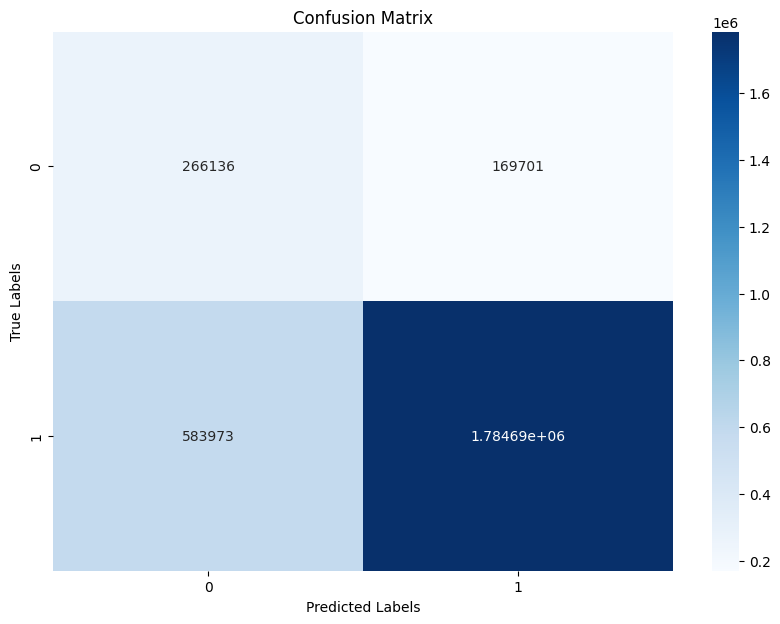

In [28]:
confusion_matrix = metrics.confusionMatrix().toArray()

print(confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  # 'g' formats numbers as integers
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()